In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL

from prophet import Prophet


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams["figure.dpi"] = 120

In [ ]:

# 1. Data Loading & Preprocessing
FILEPATH = 'Refugee_Asylum_data.xlsx'

def read_all_sheets_from_excel(filepath):
    excel_file = pd.ExcelFile(filepath, engine='openpyxl')
    sheet_names = excel_file.sheet_names
    print("Sheet names in the Excel file:")
    for sheet in sheet_names:
        print(sheet)

    dataframes = {}
    for sheet in sheet_names:
        dataframes[sheet] = pd.read_excel(filepath, sheet_name=sheet, engine='openpyxl')
    return dataframes

def clean_column_names(df):
    return {col: str(col).strip() for col in df.columns}

def convert_to_numeric(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

print('Loading data...')
dataframes = read_all_sheets_from_excel(FILEPATH)

ra_sheets = ['RA_2019', 'RA_2020', 'RA_2021', 'RA_2022', 'RA_2023', 'RA_2024']


list_df = []
for sheet in ra_sheets:
    if sheet in dataframes:
        df_temp = dataframes[sheet].copy()
        df_temp.columns = [str(col).strip() for col in df_temp.columns]
        list_df.append(df_temp)
    else:
        print(f"Sheet {sheet} not found!")

if list_df:
    ra_all = pd.concat(list_df, ignore_index=True)
else:
    raise Exception('No RA sheets found!')

print('Combined refugee/asylum data head:')
print(ra_all.head(10))

Loading data...
Sheet names in the Excel file:
Sheet1
RA_2019
RA_2020
RA_2021
RA_2022
RA_2023
Refugee_Asylum_data
RA_2024
Combined refugee/asylum data head:
   Year Country of origin Country of asylum  Refugees under UNHCR's mandate  \
0  2019       Afghanistan       Afghanistan                               0   
1  2019       Afghanistan             Egypt                              28   
2  2019       Afghanistan         Argentina                              12   
3  2019       Afghanistan           Armenia                               5   
4  2019       Afghanistan         Australia                           11585   
5  2019       Afghanistan           Austria                           37276   
6  2019       Afghanistan        Azerbaijan                             627   
7  2019       Afghanistan           Belgium                            5070   
8  2019       Afghanistan           Belarus                             213   
9  2019       Afghanistan            Brazil          

In [ ]:
# 2. Data Type Conversion & Missing Values

numeric_cols = ["Refugees under UNHCR's mandate", 'Asylum-seekers', 'Returned refugees',
                'IDPs of concern to UNHCR', 'Returned IDPss', 'Stateless persons',
                'Others of concern', 'Host Community']

ra_all = convert_to_numeric(ra_all, numeric_cols)

missing_values = ra_all.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
Other people in need of international protection    34483
Year                                                    0
Country of asylum                                       0
Country of origin                                       0
Refugees under UNHCR's mandate                          0
Asylum-seekers                                          0
IDPs of concern to UNHCR                                0
Returned refugees                                       0
Returned IDPss                                          0
Stateless persons                                       0
Others of concern                                       0
Host Community                                          0
dtype: int64



Summary Statistics:
               Year  Refugees under UNHCR's mandate  Asylum-seekers  \
count  34600.000000                    3.460000e+04    34600.000000   
mean    2021.576416                    4.492106e+03      960.869855   
std        1.705930                    7.118794e+04    10986.811413   
min     2019.000000                    0.000000e+00        0.000000   
25%     2020.000000                    5.000000e+00        0.000000   
50%     2022.000000                    1.200000e+01       10.000000   
75%     2023.000000                    8.225000e+01       80.000000   
max     2024.000000                    3.752317e+06   620074.000000   

       Returned refugees  IDPs of concern to UNHCR  Returned IDPss  \
count       34600.000000              3.460000e+04    3.460000e+04   
mean          110.960347              9.566760e+03    8.389061e+02   
std          3675.341962              2.081691e+05    3.098713e+04   
min             0.000000              0.000000e+00    0.000

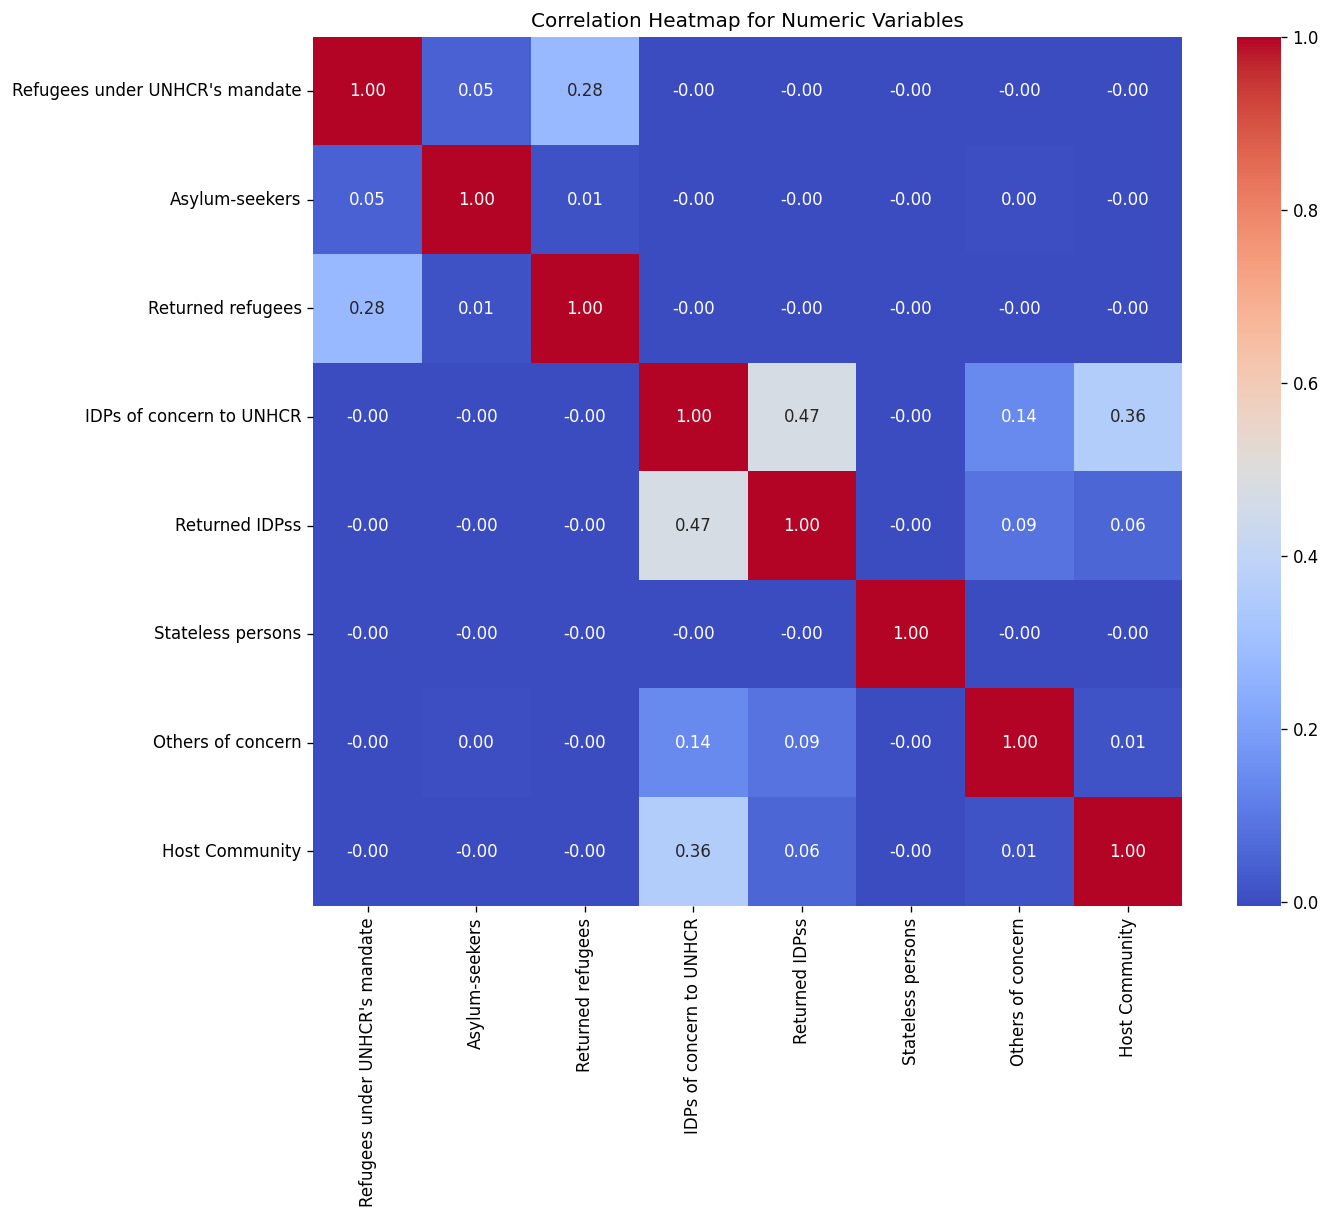

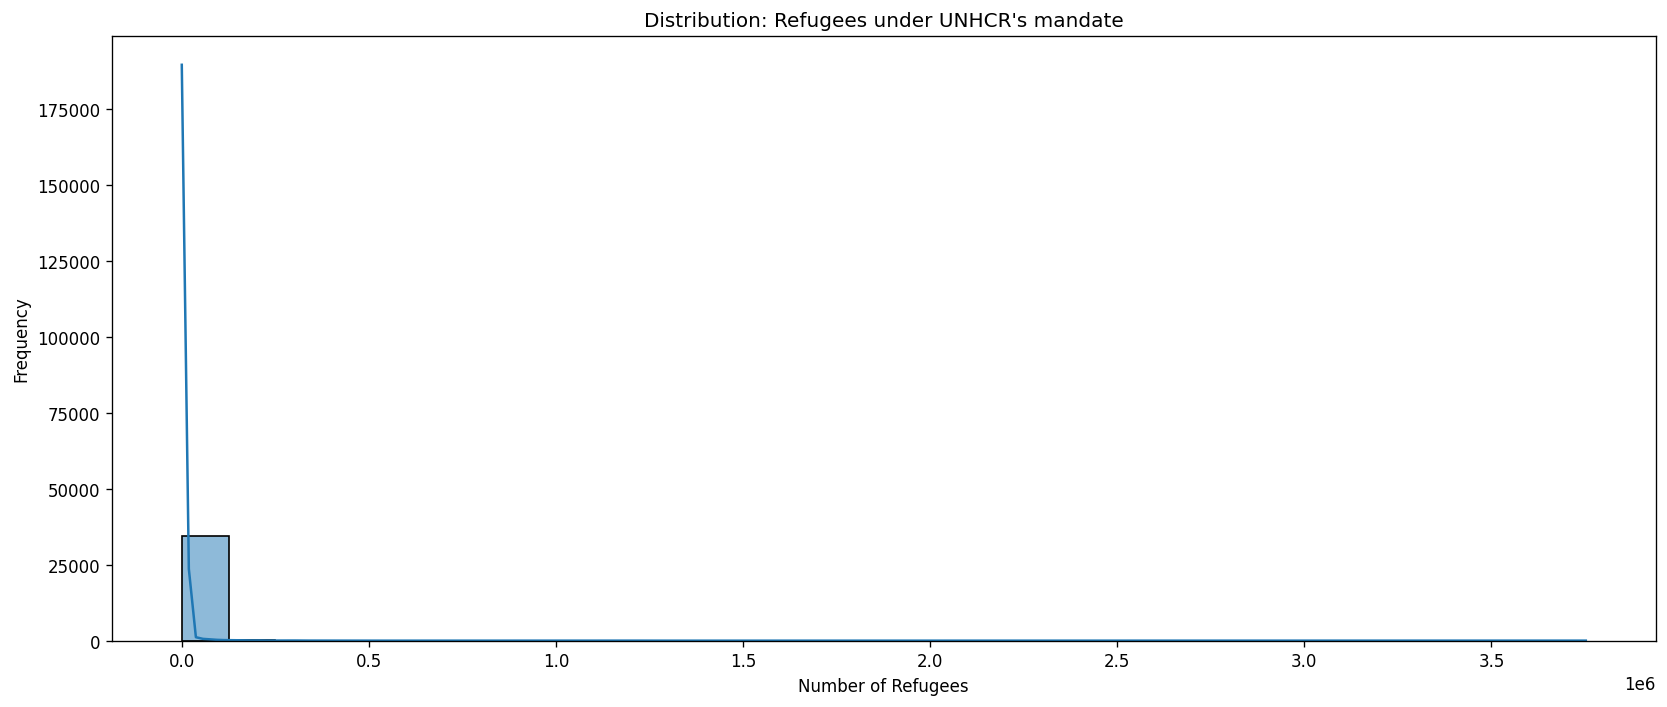

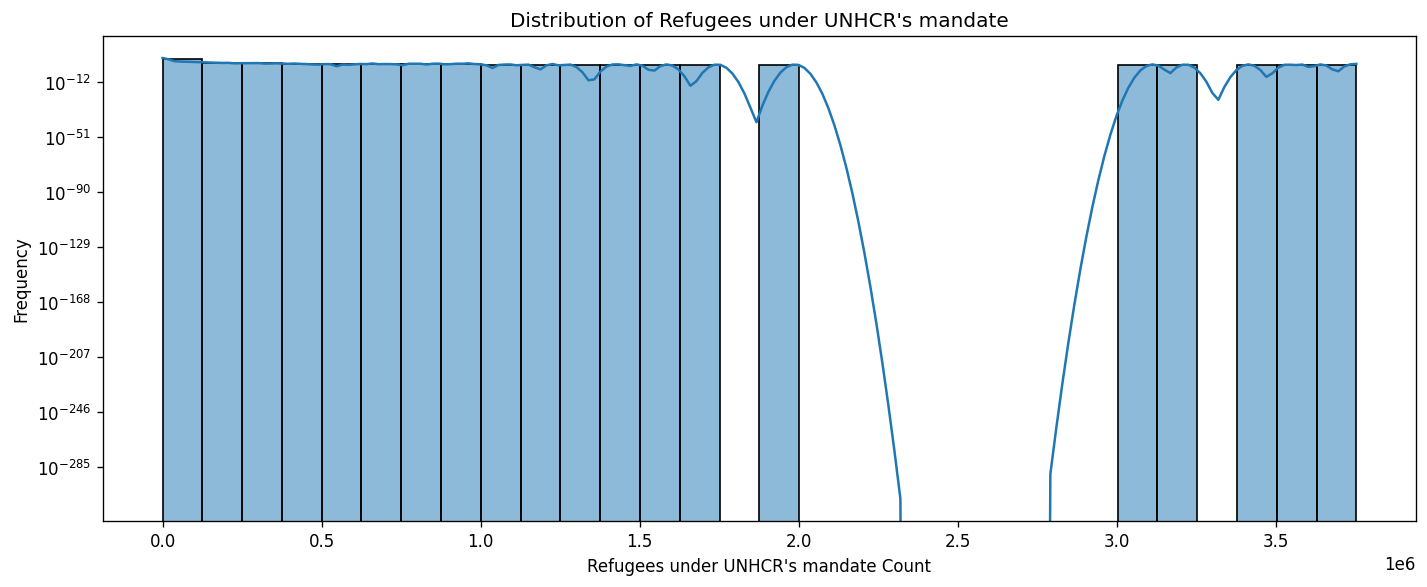

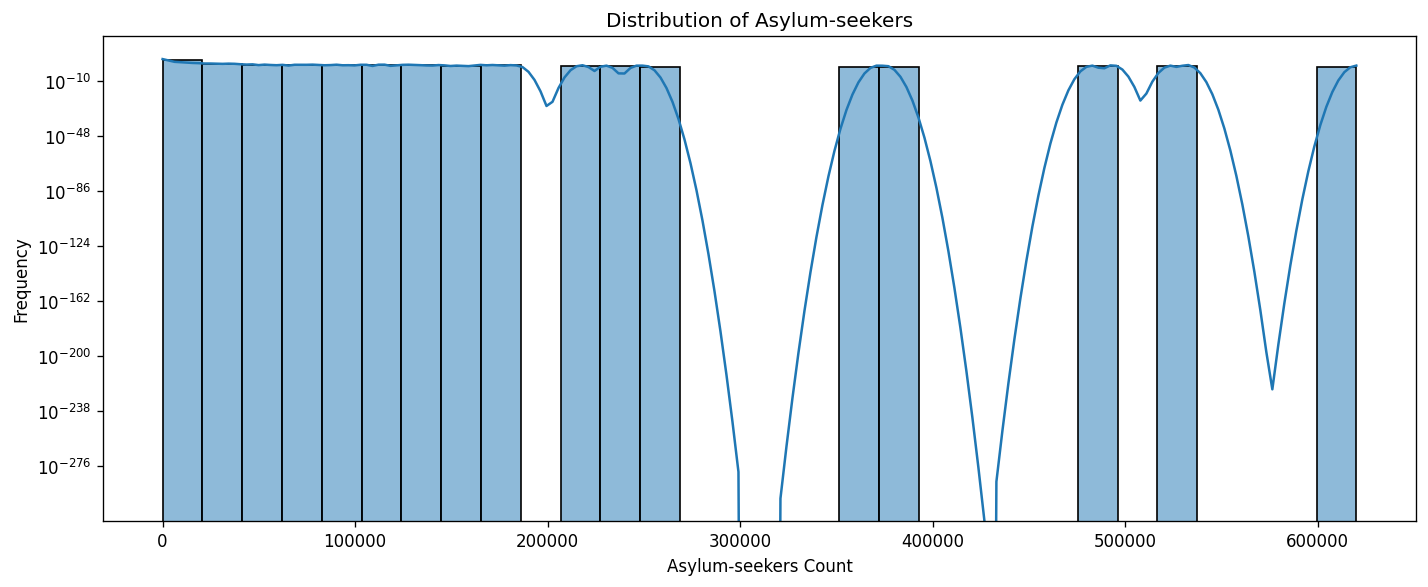

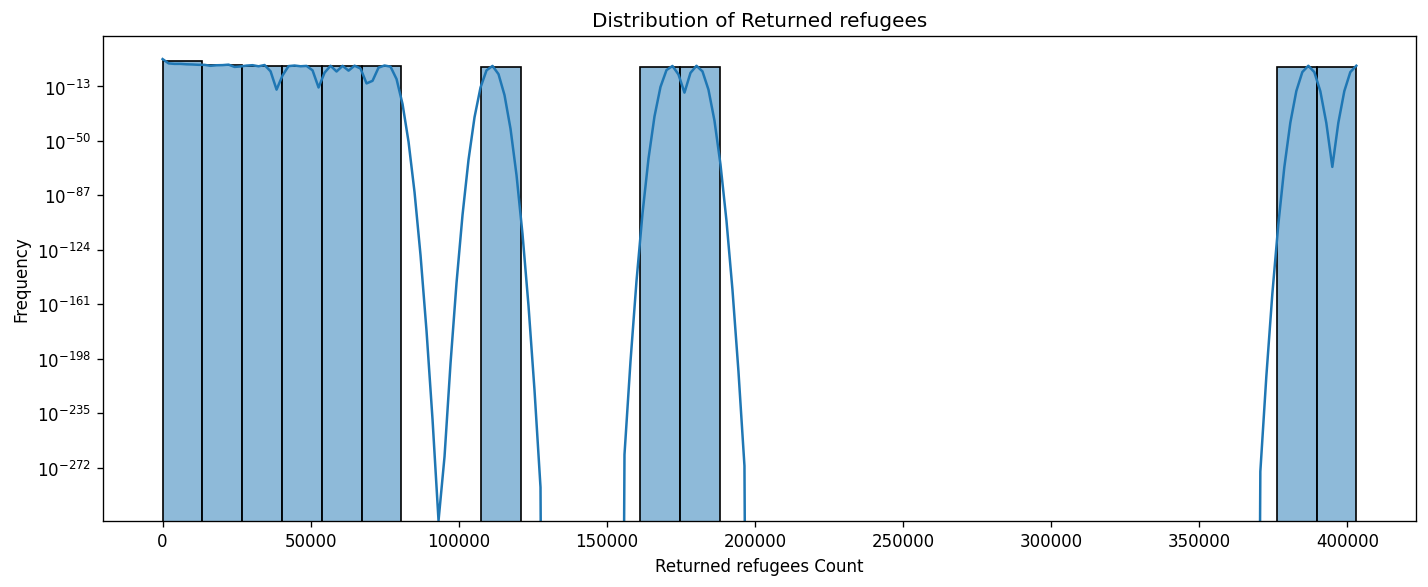

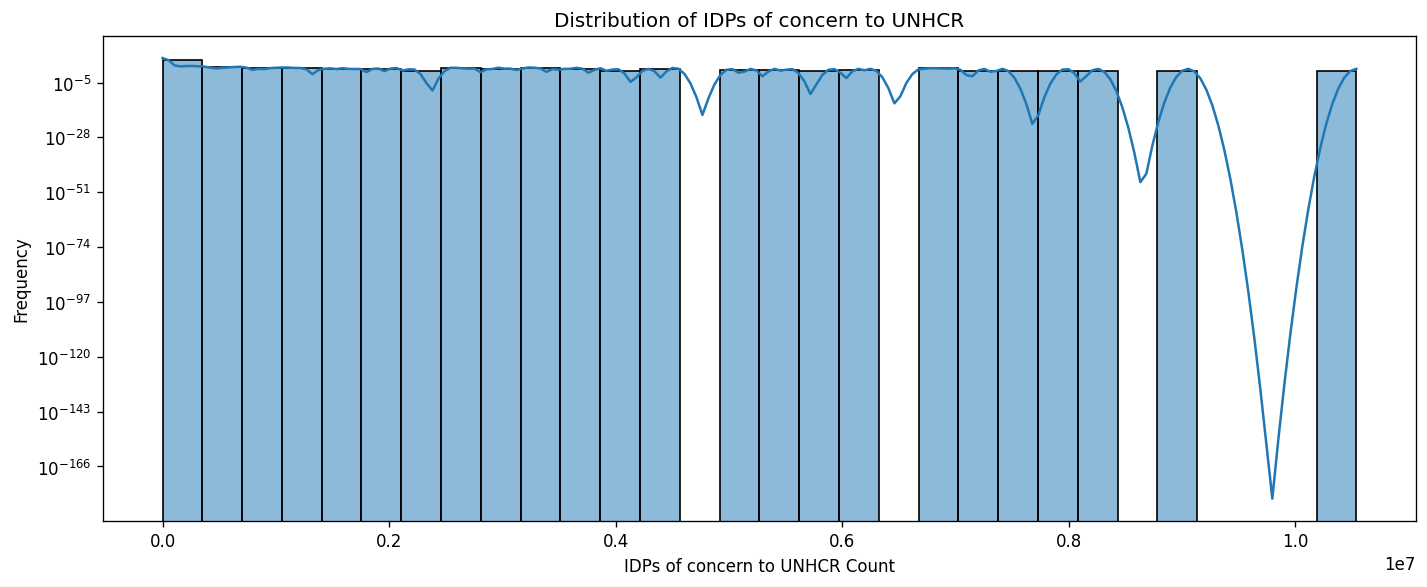

<Figure size 1680x1440 with 0 Axes>

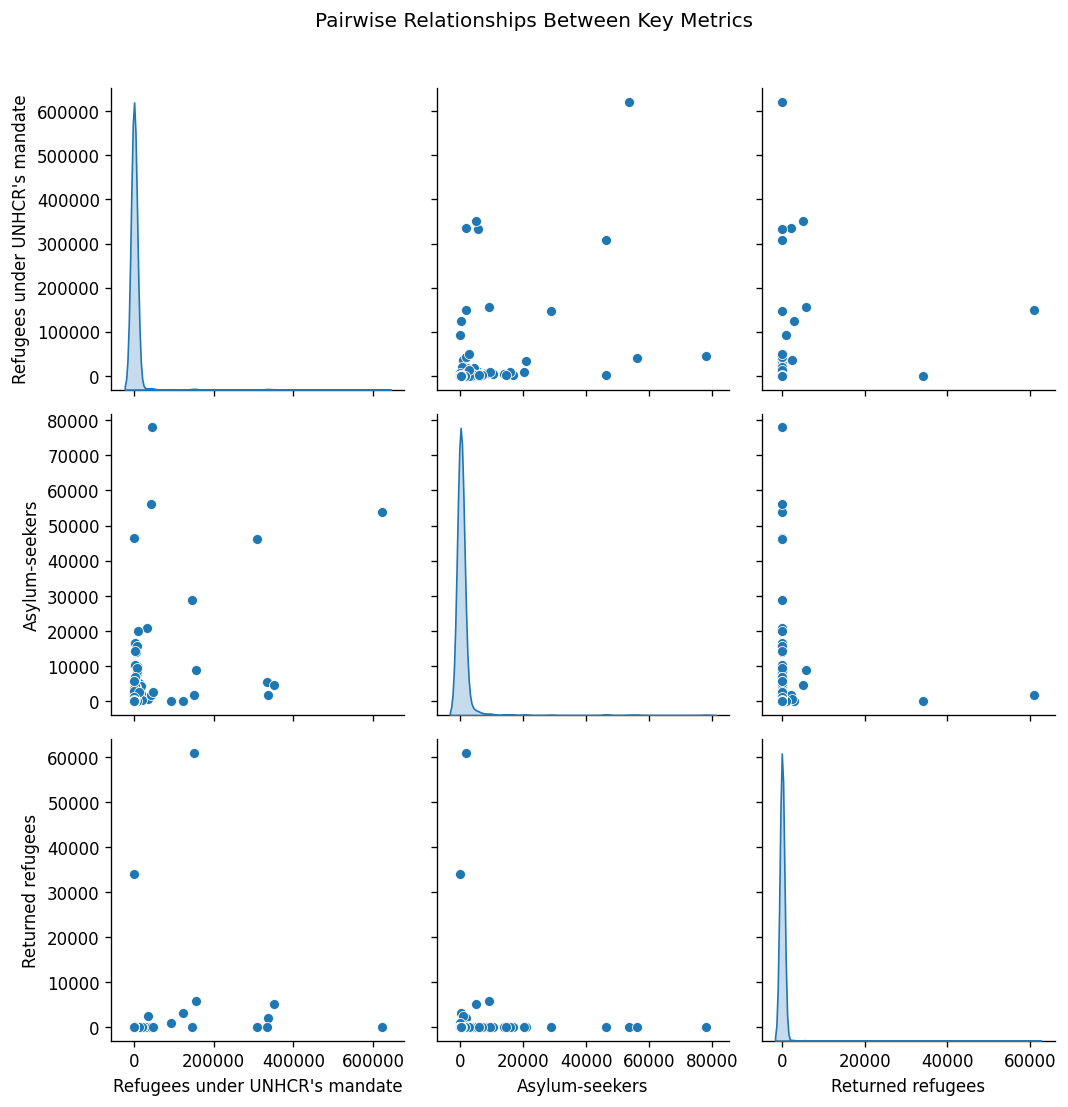

In [ ]:
# 3. Exploratory Data Analysis (EDA)

# A. Basic summary statistics and correlations
print("\nSummary Statistics:")
print(ra_all.describe())
plt.figure(figsize=(12, 10))
numeric_data = ra_all[numeric_cols].dropna()
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap for Numeric Variables')
plt.tight_layout()
plt.show()

# B. Distribution of key metrics
plt.figure(figsize=(14, 6))
sns.histplot(numeric_data["Refugees under UNHCR's mandate"], bins=30, kde=True, color='#1f77b4')
plt.title("Distribution: Refugees under UNHCR's mandate")
plt.xlabel("Number of Refugees")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# C. Expanded EDA - Univariate distributions
for col in numeric_cols[:4]:
    if col in numeric_data.columns:
        plt.figure(figsize=(12, 5))
        sns.histplot(numeric_data[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(f'{col} Count')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

# D. Expanded EDA - Pairwise scatterplots
key_metrics = ["Refugees under UNHCR's mandate", 'Asylum-seekers', 'Returned refugees']
scatter_data = numeric_data[key_metrics].sample(min(1000, len(numeric_data)))
plt.figure(figsize=(14, 12))
sns.pairplot(scatter_data, diag_kind='kde', height=3)
plt.suptitle('Pairwise Relationships Between Key Metrics', y=1.02)
plt.tight_layout()
plt.show()

# E. Seasonal decomposition via STL for time series data
def perform_stl_decomposition(series, period=12):
    if len(series) > 2*period:
        decomposition = STL(series, period=period).fit()
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
        ax1.plot(series, label='Original')
        ax1.legend()
        ax2.plot(decomposition.trend, label='Trend')
        ax2.legend()
        ax3.plot(decomposition.seasonal, label='Seasonal')
        ax3.legend()
        ax4.plot(decomposition.resid, label='Residual')
        ax4.legend()
        plt.tight_layout()
        plt.show()
        return decomposition
    return None

yearly_refugees = ra_all.groupby(['Year'])[["Refugees under UNHCR's mandate"]].sum()
if len(yearly_refugees) >= 24:
    perform_stl_decomposition(yearly_refugees["Refugees under UNHCR's mandate"], period=12)

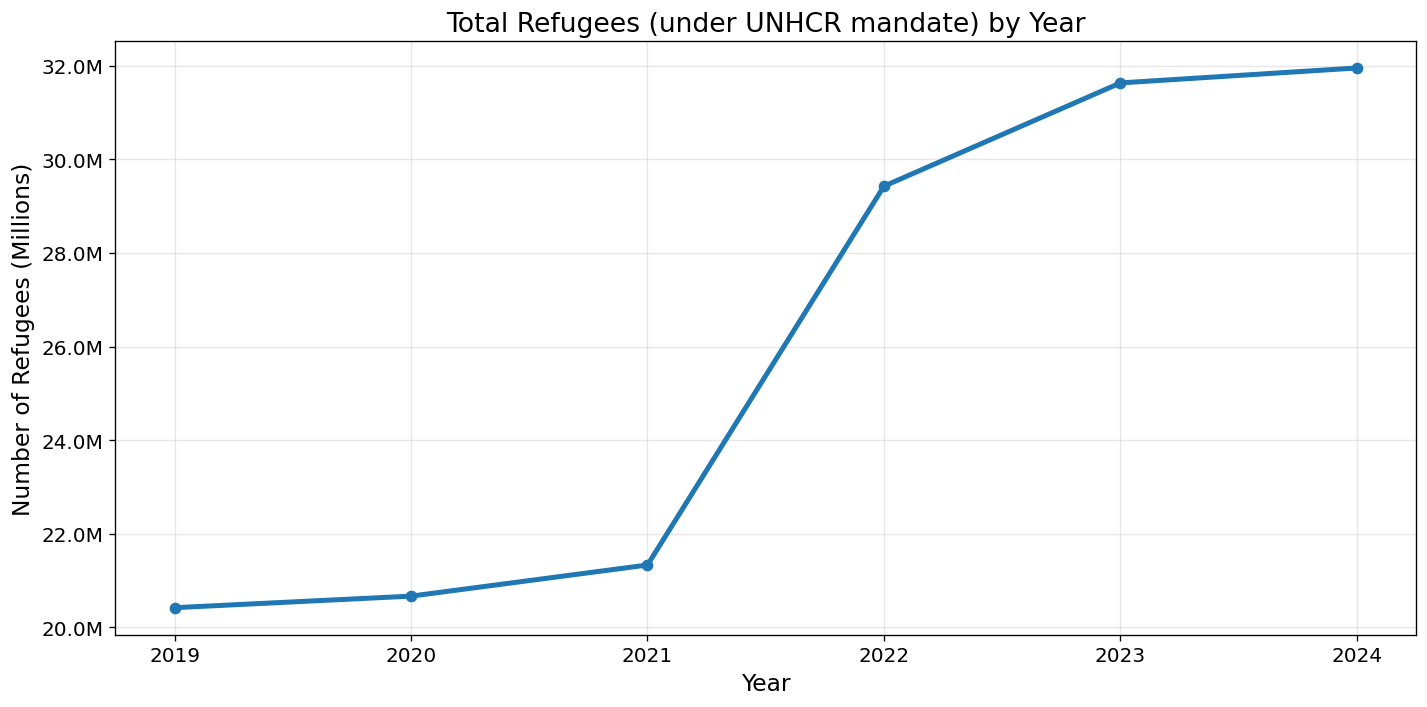

In [ ]:
# 4. Analysis 1: Trends in Total Refugees by Year
refugees_by_year = ra_all.groupby('Year')[["Refugees under UNHCR's mandate"]].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(refugees_by_year['Year'], refugees_by_year["Refugees under UNHCR's mandate"],
         marker='o', linewidth=3, color='#1f77b4')
plt.title('Total Refugees (under UNHCR mandate) by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Refugees (Millions)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(refugees_by_year['Year'], fontsize=12)
plt.yticks(fontsize=12)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000)))
plt.tight_layout()
plt.show()

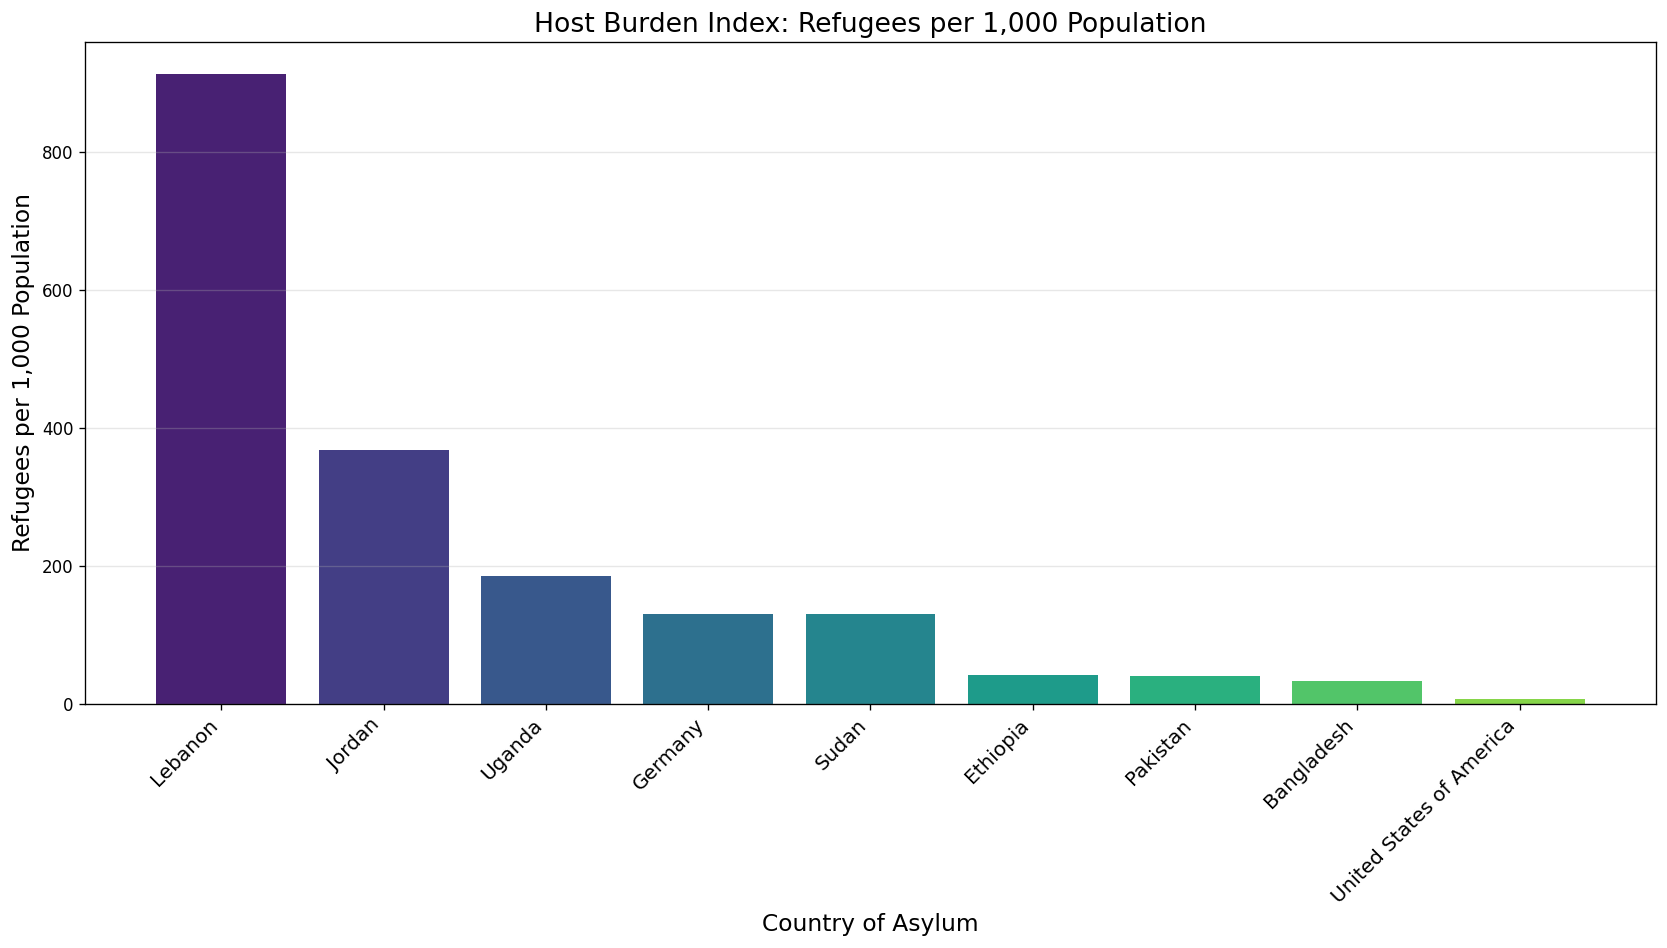

In [ ]:
# 5. Host Burden Index for Population-Normalized Analysis
population_data = {
    'Germany': 84270625,
    'Turkey': 85341241,
    'Pakistan': 235824862,
    'Lebanon': 5489739,
    'Jordan': 11285869,
    'Iran': 88550570,
    'Ethiopia': 123379924,
    'Sudan': 46874204,
    'Uganda': 48582334,
    'Bangladesh': 171186372,
    'United States of America': 336997624
}

burden_df = ra_all.groupby('Country of asylum')[["Refugees under UNHCR's mandate"]].sum().reset_index()
burden_df = burden_df[burden_df["Refugees under UNHCR's mandate"] > 0]

burden_df['Population'] = burden_df['Country of asylum'].map(population_data)
burden_df = burden_df.dropna(subset=['Population'])
burden_df['Refugees_per_1000'] = (burden_df["Refugees under UNHCR's mandate"] / burden_df['Population']) * 1000
burden_df = burden_df.sort_values('Refugees_per_1000', ascending=False)

plt.figure(figsize=(14, 8))
top_burden = burden_df.head(10)
plt.bar(top_burden['Country of asylum'], top_burden['Refugees_per_1000'], color=sns.color_palette("viridis", 10))
plt.title('Host Burden Index: Refugees per 1,000 Population', fontsize=16)
plt.xlabel('Country of Asylum', fontsize=14)
plt.ylabel('Refugees per 1,000 Population', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6nle9vk9/aw6mz9qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6nle9vk9/5kj9_f2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1459', 'data', 'file=/tmp/tmp6nle9vk9/aw6mz9qu.json', 'init=/tmp/tmp6nle9vk9/5kj9_f2s.json', 'output', 'file=/tmp/tmp6nle9vk9/prophet_modelacq7yxkk/prophet_model-20250502200415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:04:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

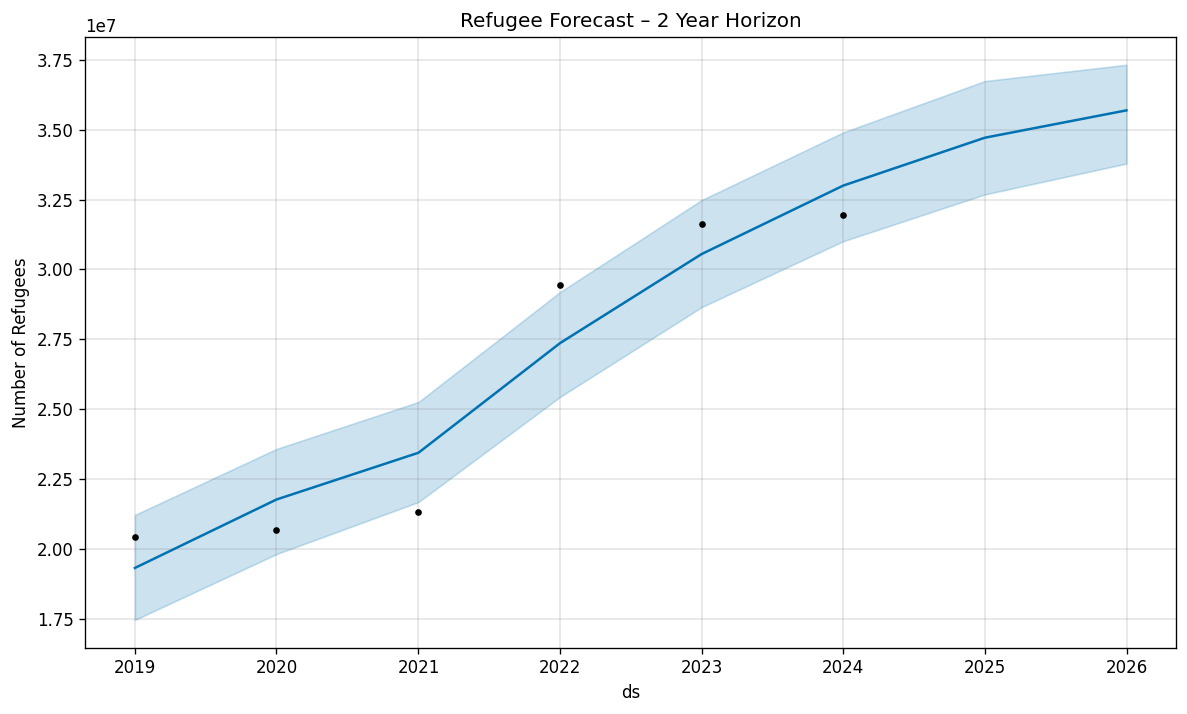

In [ ]:
# 6. Time Series Forecasting using Prophet
if len(refugees_by_year) >= 3:
    prophet_df = refugees_by_year.copy()
    prophet_df['ds'] = pd.to_datetime(prophet_df['Year'].astype(str) + '-01-01')
    prophet_df['y']  = prophet_df["Refugees under UNHCR's mandate"]
    prophet_df = prophet_df[['ds','y']]
    model = Prophet(yearly_seasonality=True, growth='linear')
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=2, freq='Y')
    forecast = model.predict(future)

    fig1 = model.plot(forecast, uncertainty=True)
    ax = fig1.gca()
    ax.set_title('Refugee Forecast – 2 Year Horizon')
    ax.set_ylabel('Number of Refugees')



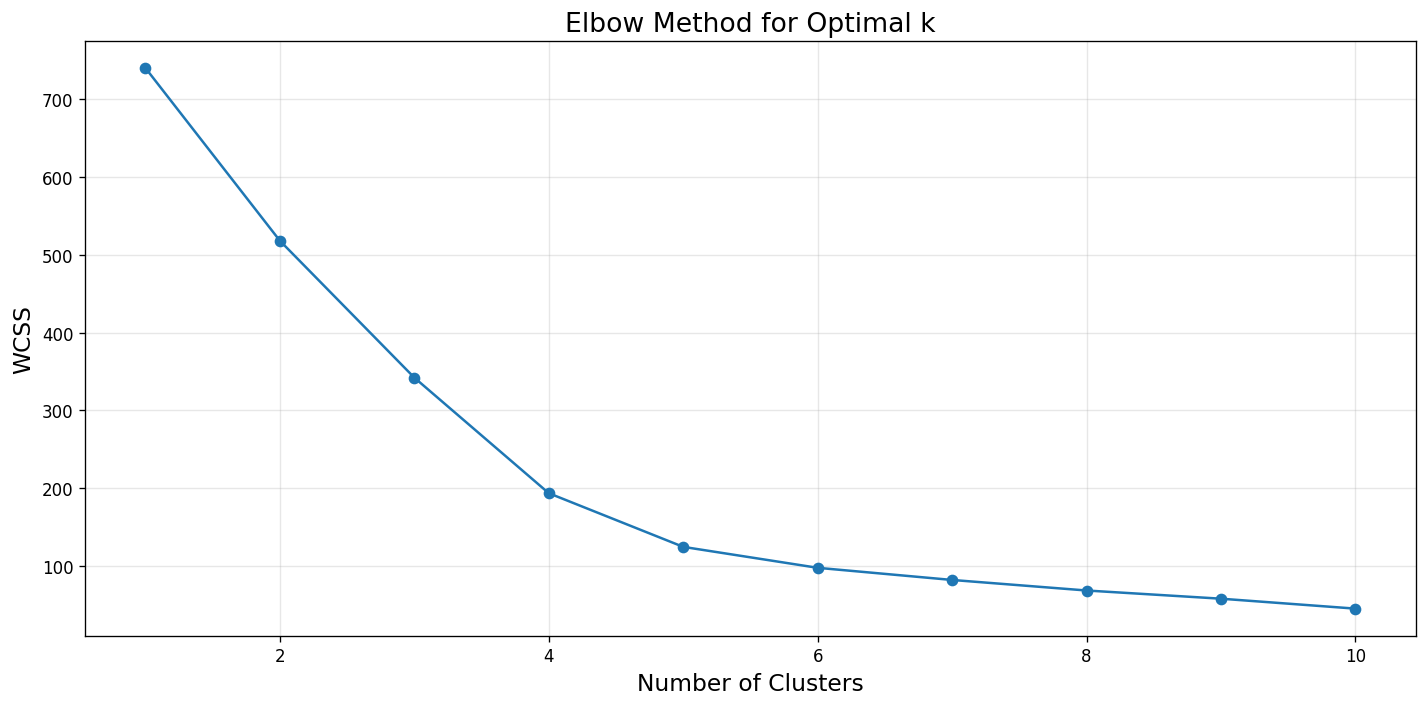


Clustering Results:

Cluster 0:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Benin' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Rep.' 'Chad' 'Chile' 'China' 'China, Hong Kong SAR'
 'Colombia' 'Comoros' 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Curacao '
 'Cyprus' 'Czechia' 'Dem. Rep. of the Congo' 'Denmark' 'Djibouti'
 'Dominican Rep.' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia'
 'Georgia' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau'
 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jorda

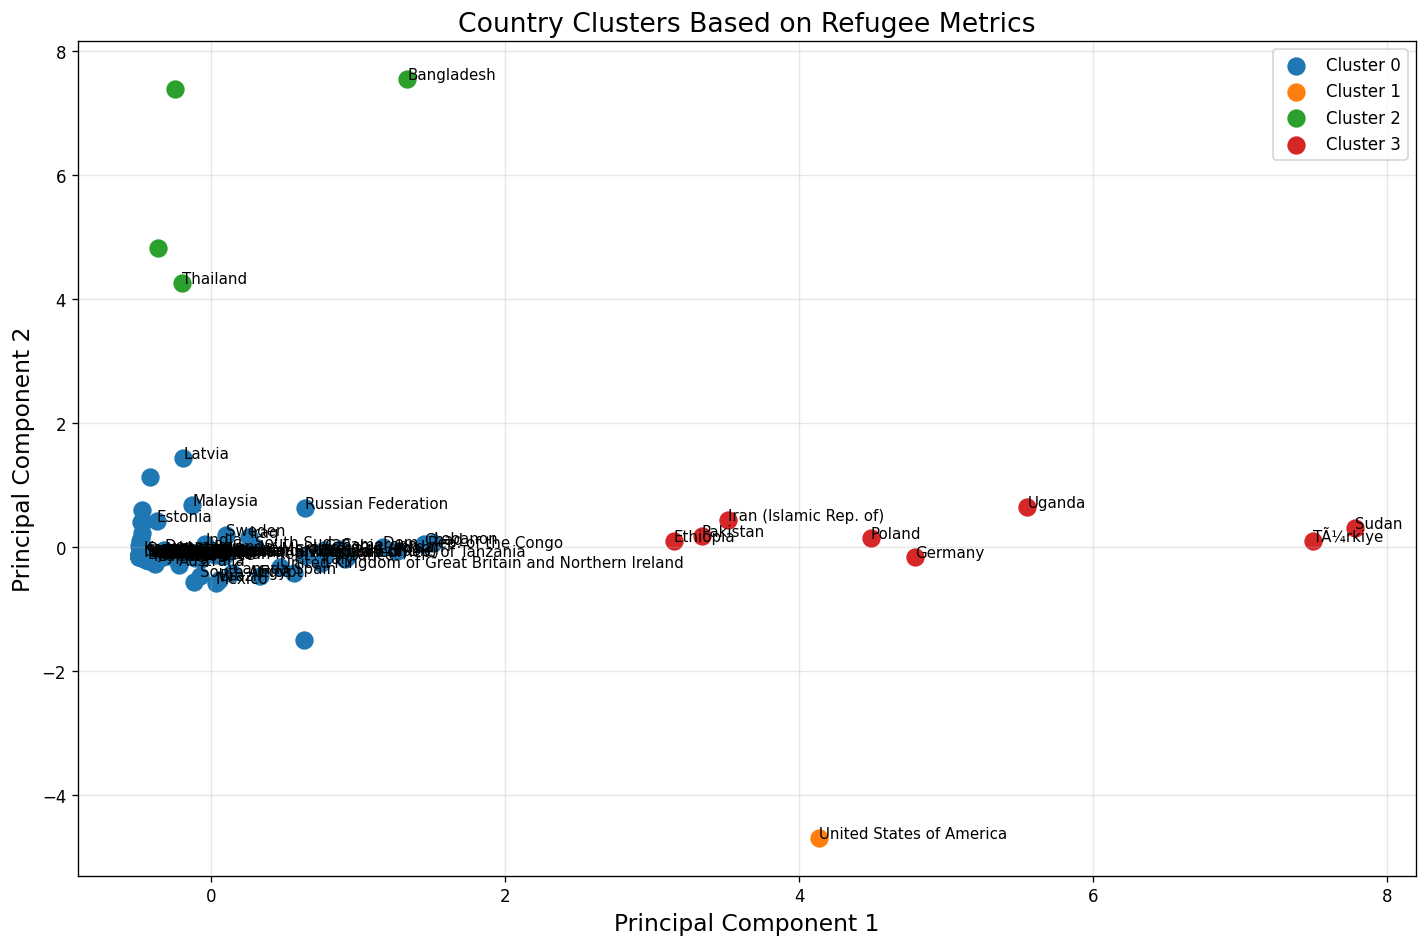

In [ ]:
# 7. K-Means Clustering of Asylum Countries

cluster_features = ra_all.groupby('Country of asylum').agg({
    "Refugees under UNHCR's mandate": 'sum',
    'Asylum-seekers': 'sum',
    'Returned refugees': 'sum',
    'Stateless persons': 'sum'
}).reset_index()

cluster_data = cluster_features.drop('Country of asylum', axis=1)
cluster_data = cluster_data.fillna(0)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

wcss = []
max_clusters = min(10, len(scaled_data)-1)
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

cluster_features['Cluster'] = clusters
print("\nClustering Results:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(cluster_features[cluster_features['Cluster'] == cluster]['Country of asylum'].values)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['Country'] = cluster_features['Country of asylum']

plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    plt.scatter(
        pca_df[pca_df['Cluster'] == cluster]['PC1'],
        pca_df[pca_df['Cluster'] == cluster]['PC2'],
        label=f'Cluster {cluster}',
        s=100
    )

for i, txt in enumerate(pca_df['Country']):
    if cluster_features.iloc[i]["Refugees under UNHCR's mandate"] > 100000:
        plt.annotate(txt, (pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2']), fontsize=9)

plt.title('Country Clusters Based on Refugee Metrics', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

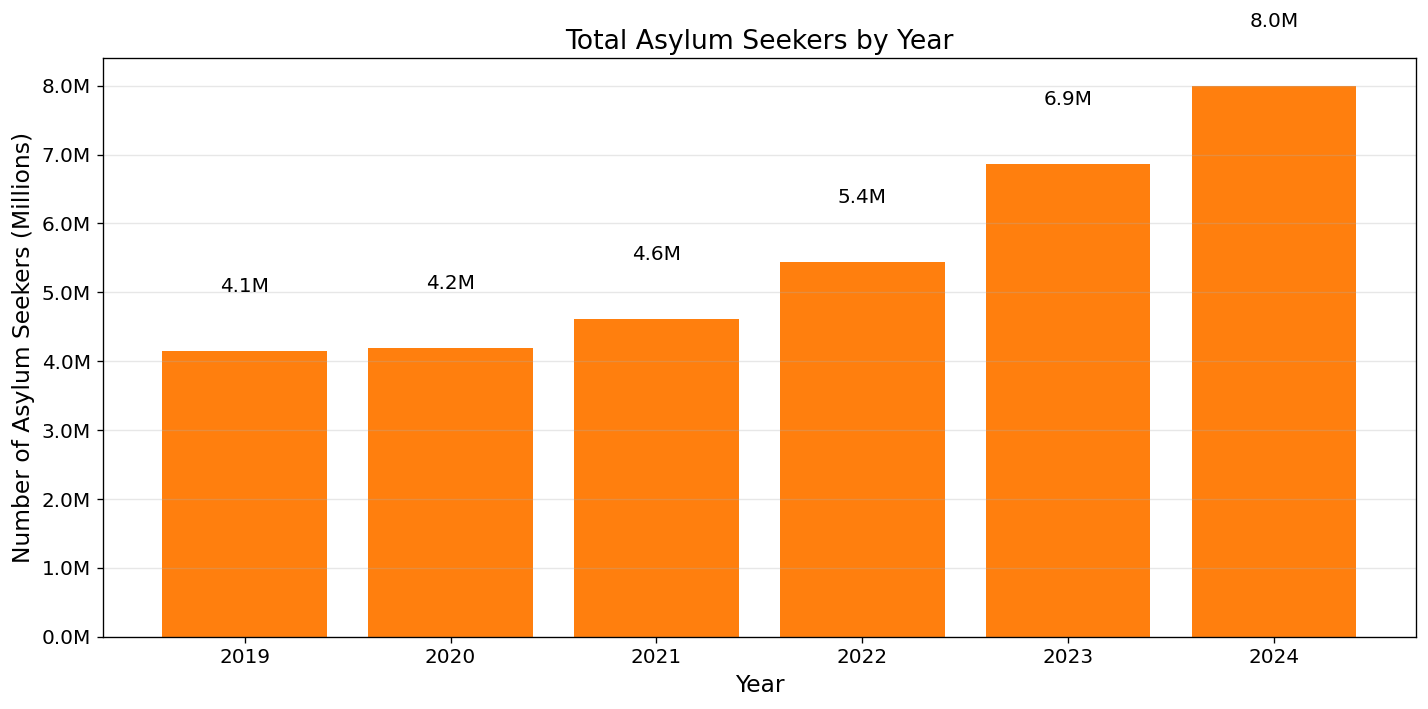

In [ ]:
# 8. Analysis 2: Asylum Seekers by Year
asylum_by_year = ra_all.groupby('Year')['Asylum-seekers'].sum().reset_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(asylum_by_year['Year'].astype(str), asylum_by_year['Asylum-seekers'], color='#ff7f0e')
plt.title('Total Asylum Seekers by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Asylum Seekers (Millions)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * asylum_by_year['Asylum-seekers'].max(),
             '{:.1f}M'.format(height/1000000), ha='center', va='bottom', fontsize=12)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000)))
plt.tight_layout()
plt.show()



Top 10 Origin-Asylum Country Pairs by Total Asylum Seekers:
                        Country of origin         Country of asylum  Year  \
33375  Venezuela (Bolivarian Republic of)  United States of America  2024   
33302  Venezuela (Bolivarian Republic of)                      Peru  2020   
33303  Venezuela (Bolivarian Republic of)                      Peru  2021   
33304  Venezuela (Bolivarian Republic of)                      Peru  2022   
33374  Venezuela (Bolivarian Republic of)  United States of America  2023   
33305  Venezuela (Bolivarian Republic of)                      Peru  2023   
33306  Venezuela (Bolivarian Republic of)                      Peru  2024   
33301  Venezuela (Bolivarian Republic of)                      Peru  2019   
27972                               Sudan                     Egypt  2024   
33373  Venezuela (Bolivarian Republic of)  United States of America  2022   

       Asylum-seekers  
33375          620074  
33302          532303  
33303          5318

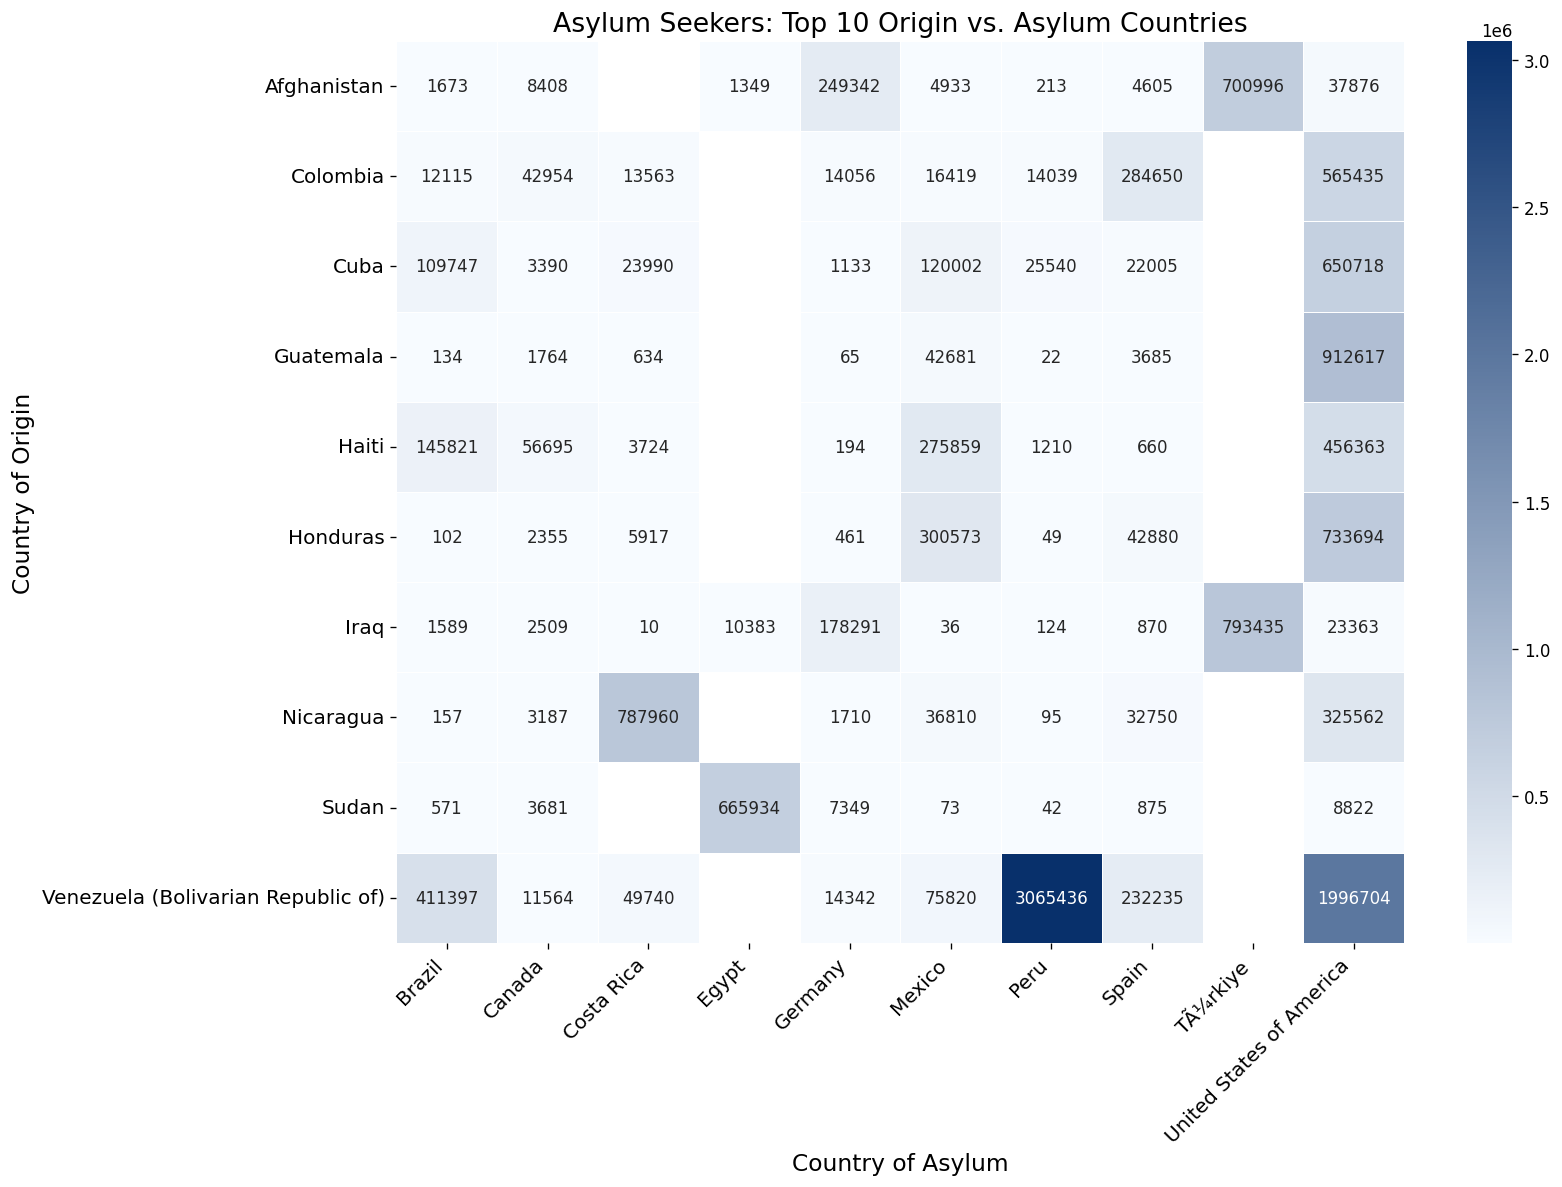

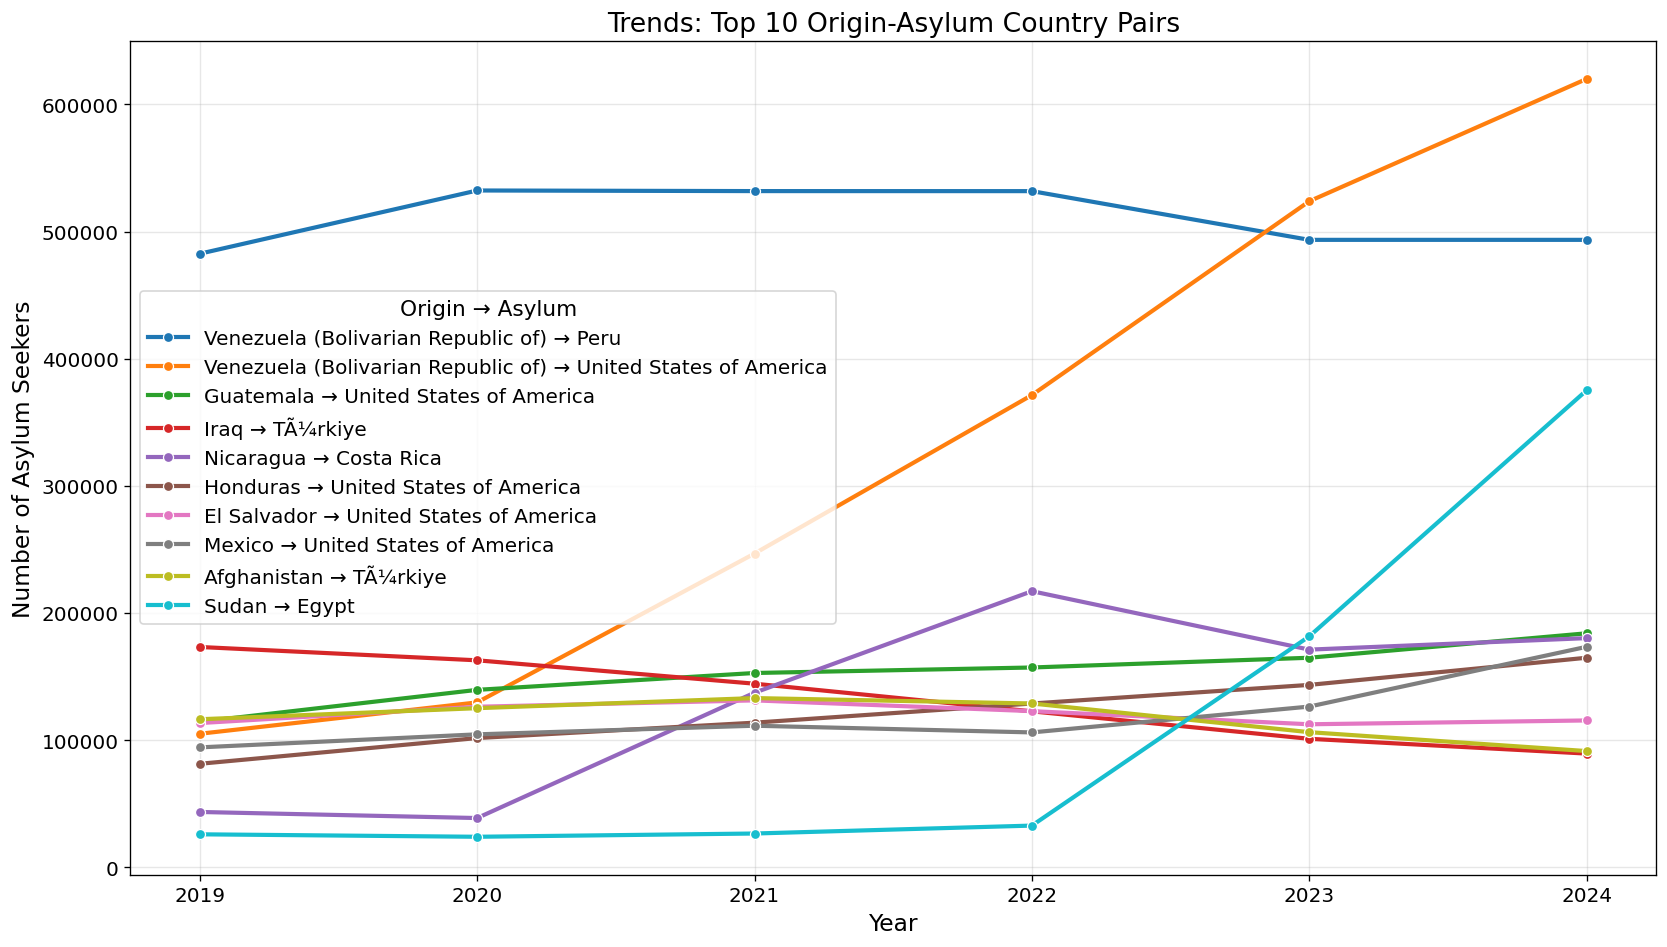

In [ ]:
# 10. Analysis 3: Origin vs Asylum Country Patterns
origin_asylum = ra_all.groupby(['Country of origin', 'Country of asylum', 'Year'])['Asylum-seekers'].sum().reset_index()
origin_asylum = origin_asylum.sort_values(by='Asylum-seekers', ascending=False)

print("\nTop 10 Origin-Asylum Country Pairs by Total Asylum Seekers:")
print(origin_asylum.head(10)[['Country of origin', 'Country of asylum', 'Year', 'Asylum-seekers']])

top_origins = origin_asylum.groupby('Country of origin')['Asylum-seekers'].sum().nlargest(10).index
top_asylums = origin_asylum.groupby('Country of asylum')['Asylum-seekers'].sum().nlargest(10).index

filtered_data = origin_asylum[
    (origin_asylum['Country of origin'].isin(top_origins)) &
    (origin_asylum['Country of asylum'].isin(top_asylums))
]

pivot_data = filtered_data.groupby(['Country of origin', 'Country of asylum'])['Asylum-seekers'].sum().reset_index()
pivot_table = pivot_data.pivot(index='Country of origin', columns='Country of asylum', values='Asylum-seekers')

plt.figure(figsize=(14, 10))
mask = np.isnan(pivot_table)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f7fbff', '#08306b'])
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap=cmap, mask=mask, linewidths=0.5,
            annot_kws={"size": 10})
plt.title('Asylum Seekers: Top 10 Origin vs. Asylum Countries', fontsize=16)
plt.xlabel('Country of Asylum', fontsize=14)
plt.ylabel('Country of Origin', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

top10_pairs = origin_asylum.groupby(['Country of origin', 'Country of asylum'])['Asylum-seekers'] \
    .sum().nlargest(10).reset_index()
top10_pairs_list = list(zip(top10_pairs['Country of origin'], top10_pairs['Country of asylum']))

trend_data = []
for origin, asylum in top10_pairs_list:
    subset = origin_asylum[(origin_asylum['Country of origin'] == origin) &
                           (origin_asylum['Country of asylum'] == asylum)]
    for _, row in subset.iterrows():
        trend_data.append({
            'Origin-Asylum': f"{origin} → {asylum}",
            'Year': row['Year'],
            'Asylum-seekers': row['Asylum-seekers']
        })
trend_df = pd.DataFrame(trend_data)

plt.figure(figsize=(14, 8))
sns.lineplot(data=trend_df, x='Year', y='Asylum-seekers', hue='Origin-Asylum',
             marker='o', linewidth=2.5)
plt.title('Trends: Top 10 Origin-Asylum Country Pairs', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Asylum Seekers', fontsize=14)
plt.xticks(trend_df['Year'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Origin → Asylum', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

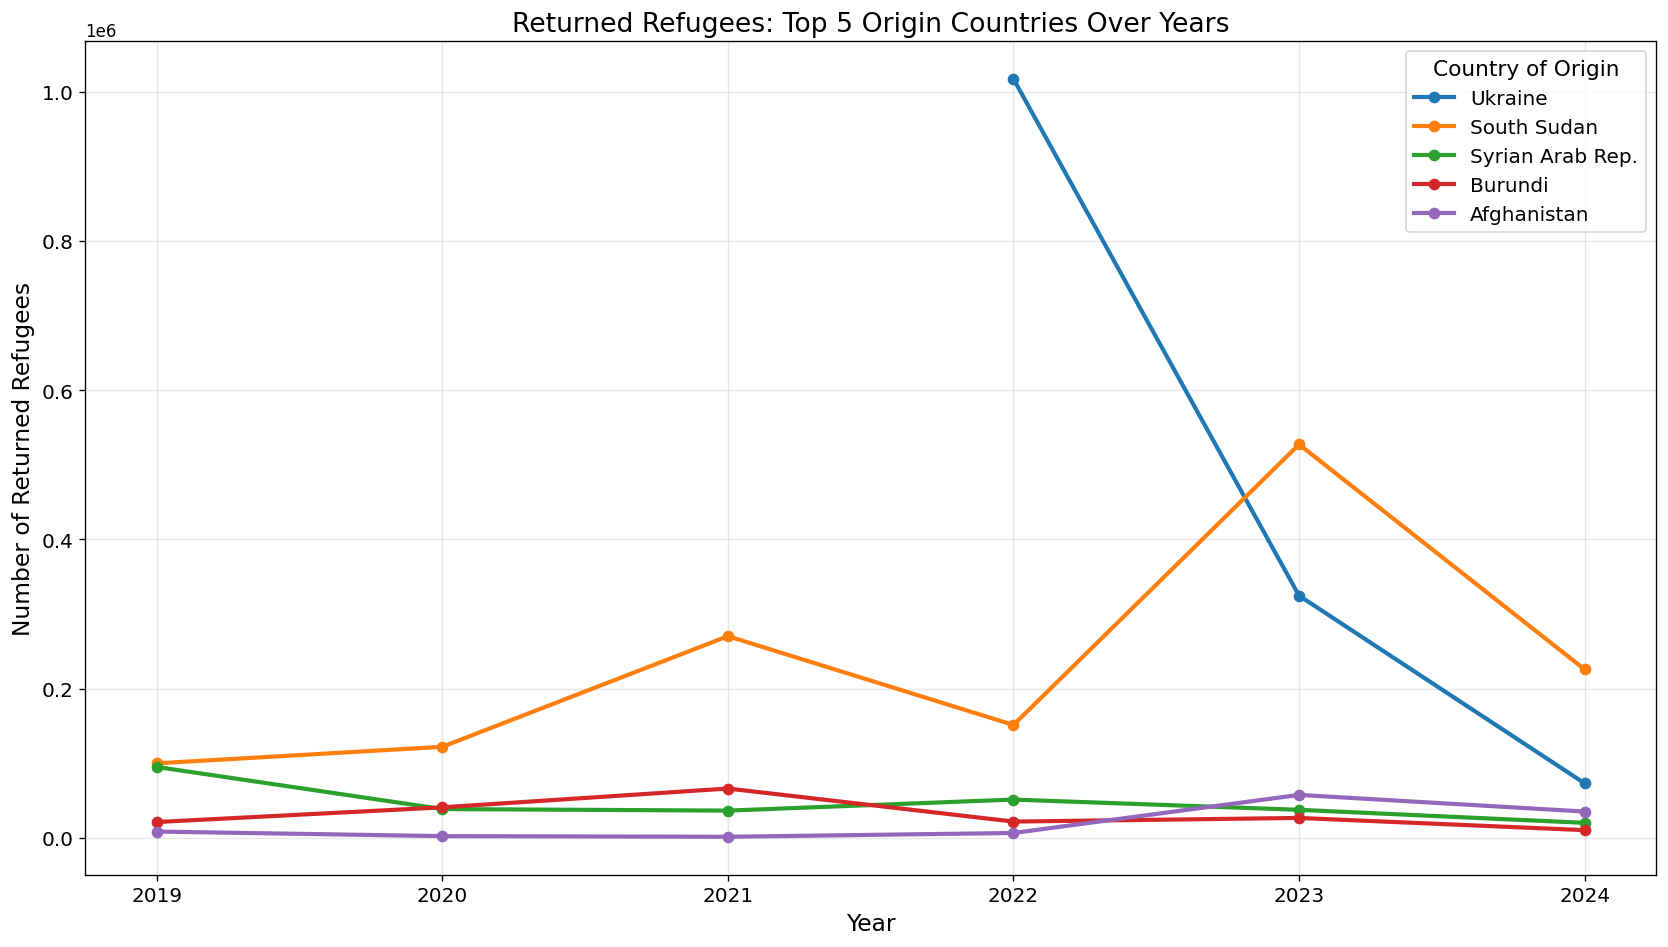

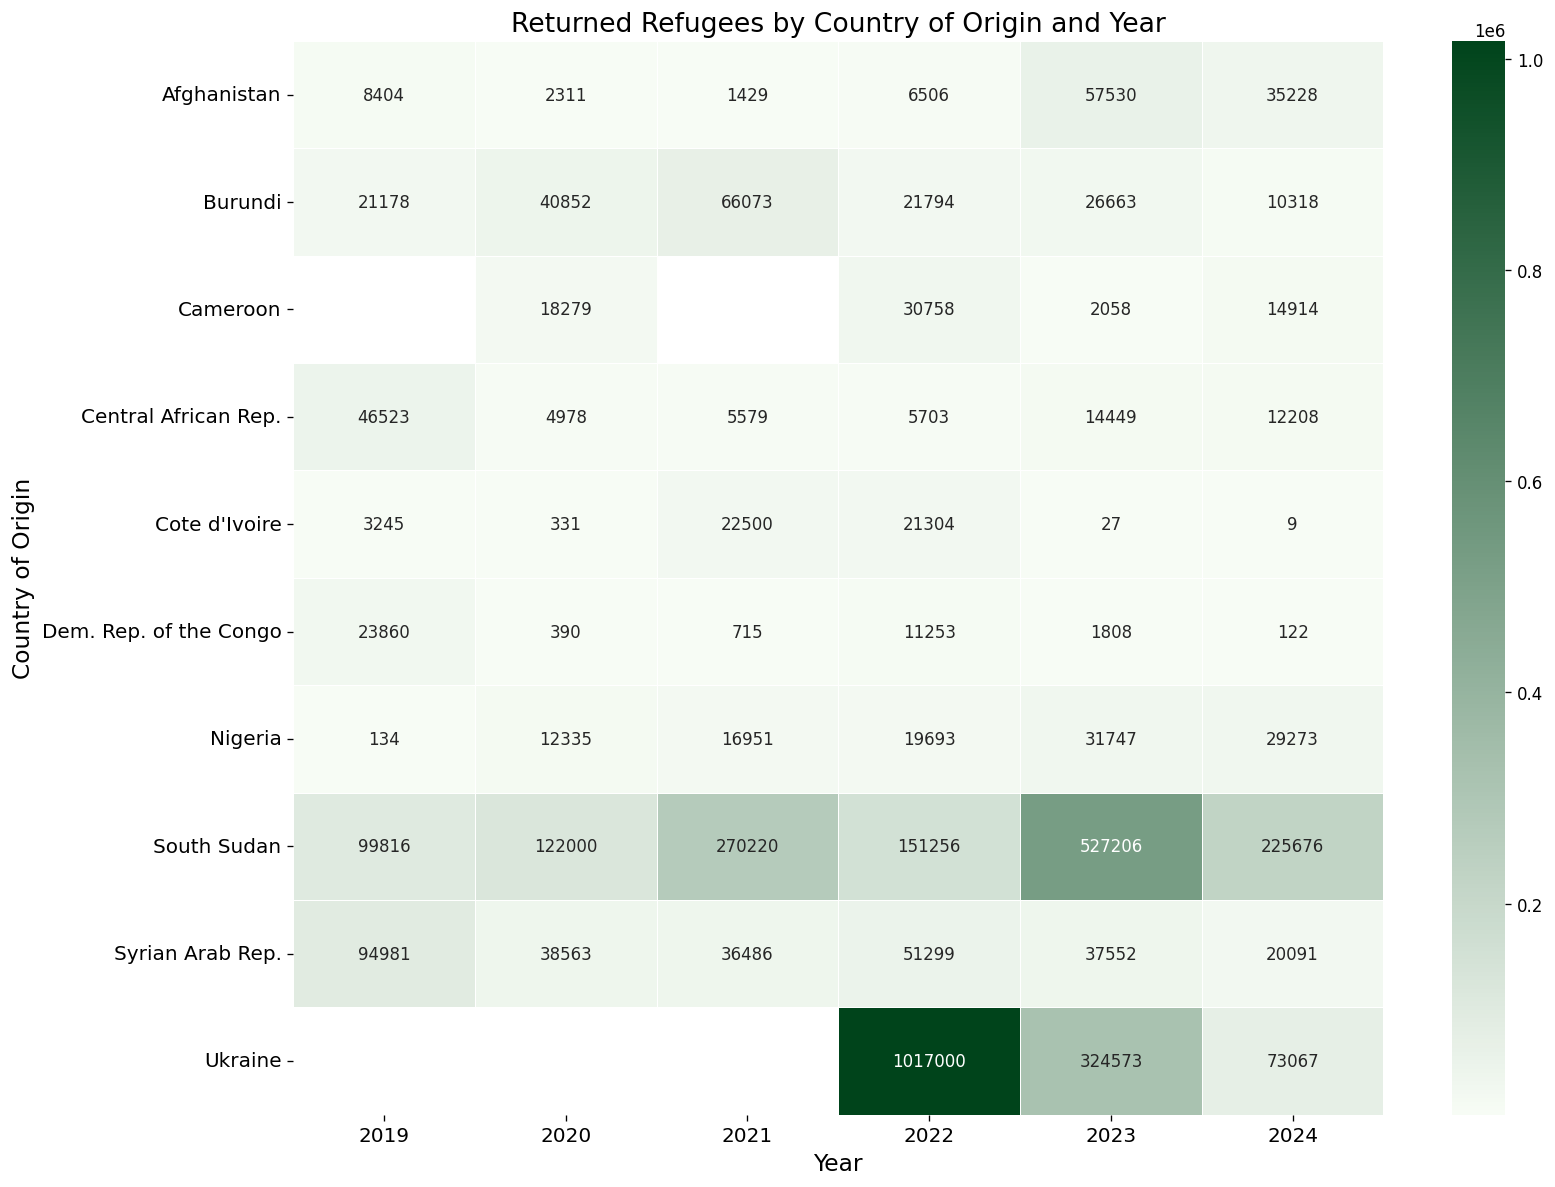

In [ ]:
# 11. Analysis 4: Returned Refugees Patterns
returned_by_year_origin = ra_all.groupby(['Year', 'Country of origin'])['Returned refugees'].sum().reset_index()
returned_by_year_origin = returned_by_year_origin[returned_by_year_origin['Returned refugees'] > 0]

top_origins_returned = returned_by_year_origin.groupby('Country of origin')['Returned refugees'] \
    .sum().nlargest(5).index

plt.figure(figsize=(14, 8))
for origin in top_origins_returned:
    subset = returned_by_year_origin[returned_by_year_origin['Country of origin'] == origin]
    plt.plot(subset['Year'], subset['Returned refugees'], marker='o', linewidth=2.5, label=origin)
plt.title('Returned Refugees: Top 5 Origin Countries Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Returned Refugees', fontsize=14)
plt.xticks(returned_by_year_origin['Year'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Country of Origin', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

top10_return_countries = returned_by_year_origin.groupby('Country of origin')['Returned refugees'] \
    .sum().nlargest(10).index
return_heatmap_data = returned_by_year_origin[returned_by_year_origin['Country of origin']
                                              .isin(top10_return_countries)]
return_pivot = return_heatmap_data.pivot(index='Country of origin', columns='Year', values='Returned refugees')

plt.figure(figsize=(14, 10))
mask = np.isnan(return_pivot)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f7fcf5', '#00441b'])
sns.heatmap(return_pivot, annot=True, fmt='.0f', cmap=cmap, mask=mask,
            linewidths=0.5, annot_kws={"size": 10})
plt.title('Returned Refugees by Country of Origin and Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Country of Origin', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

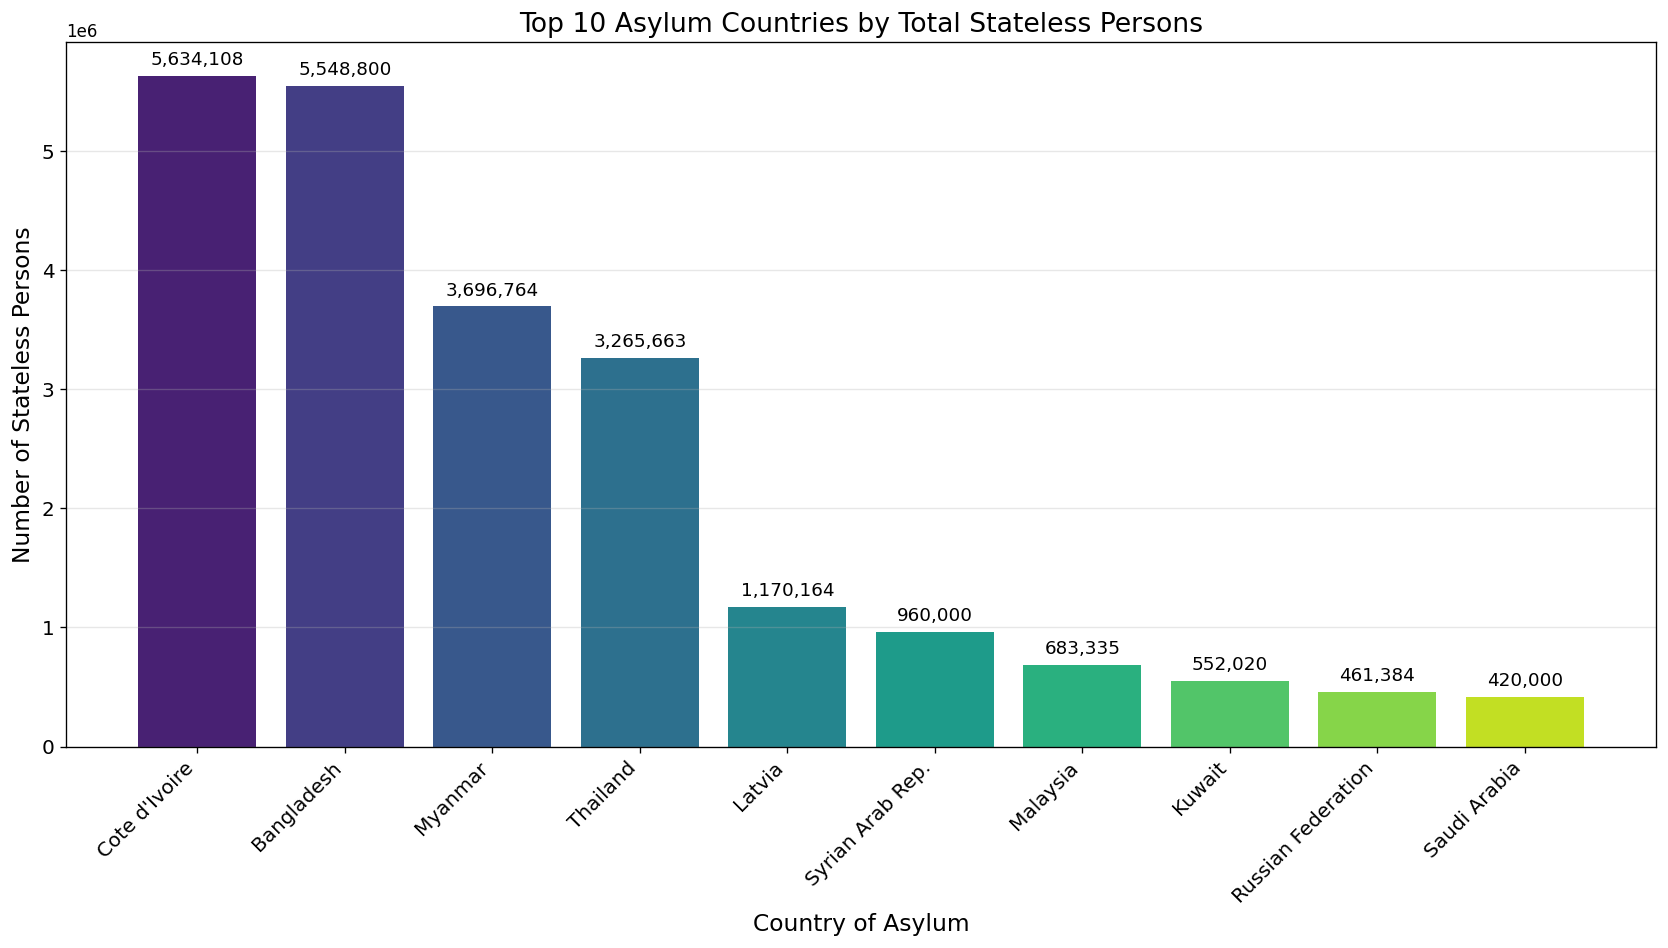

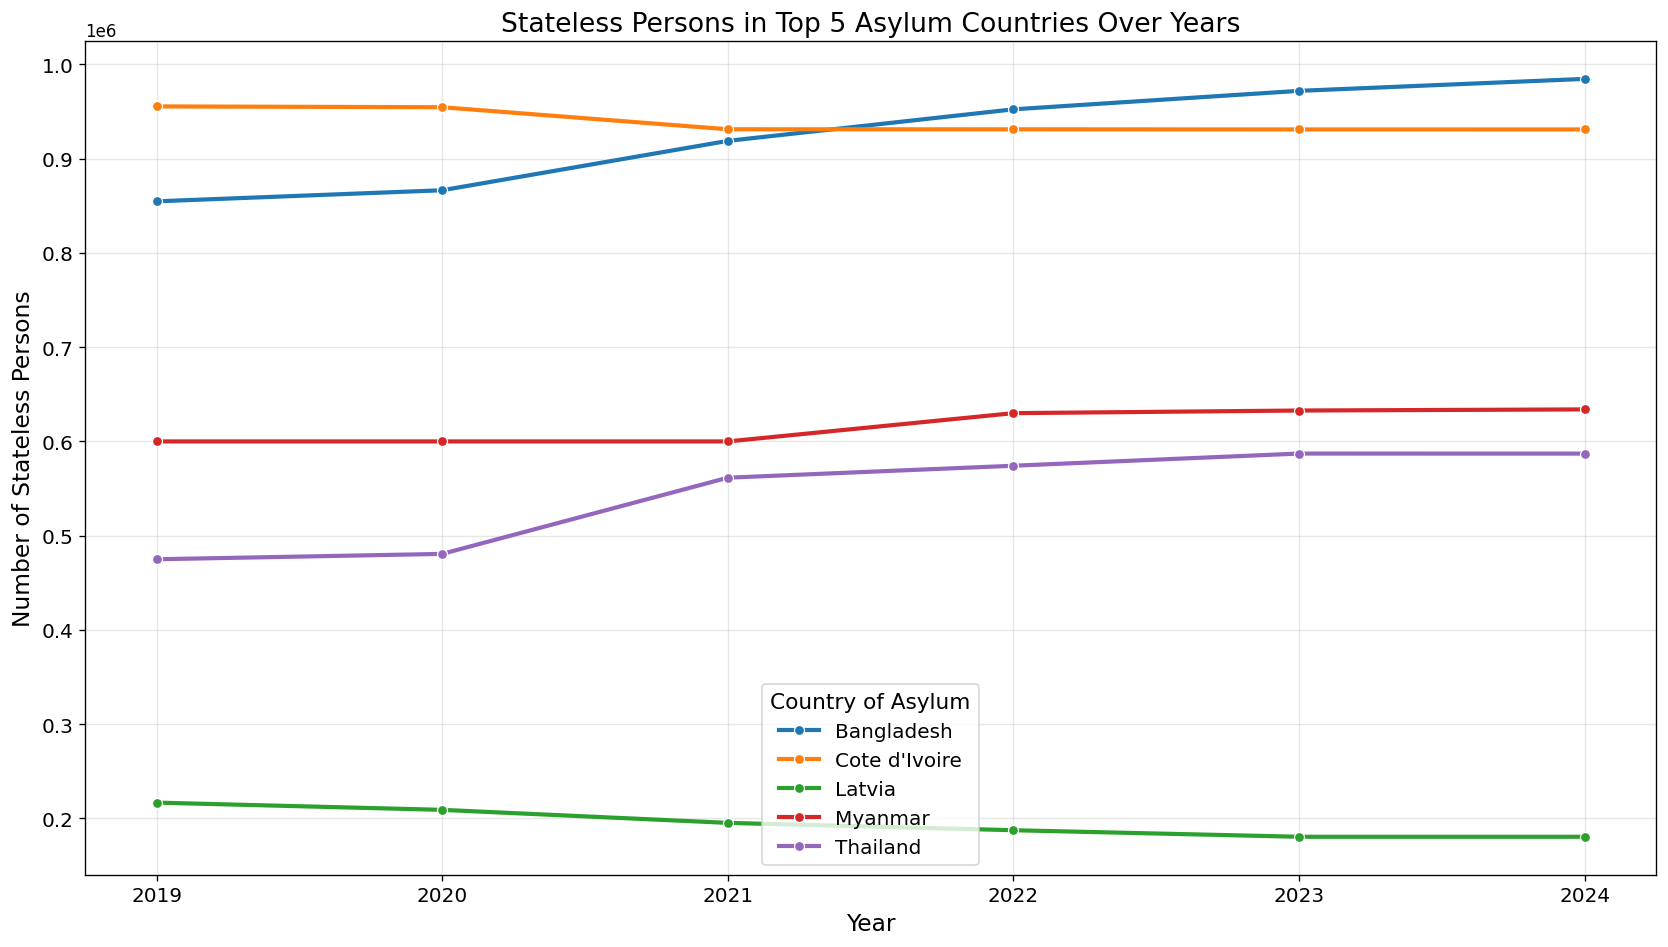

In [ ]:
# 12. Analysis 5: Stateless Persons Analysis
total_stateless = ra_all.groupby('Country of asylum')['Stateless persons'].sum().reset_index()
total_stateless = total_stateless[total_stateless['Stateless persons'] > 0]
total_stateless = total_stateless.sort_values(by='Stateless persons', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(total_stateless.head(10)['Country of asylum'],
               total_stateless.head(10)['Stateless persons'],
               color=sns.color_palette("viridis", 10))
plt.title('Top 10 Asylum Countries by Total Stateless Persons', fontsize=16)
plt.xlabel('Country of Asylum', fontsize=14)
plt.ylabel('Number of Stateless Persons', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * total_stateless.head(10)['Stateless persons'].max(),
             '{:,.0f}'.format(height), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

stateless_by_year = ra_all.groupby(['Year', 'Country of asylum'])['Stateless persons'].sum().reset_index()
stateless_by_year = stateless_by_year[stateless_by_year['Stateless persons'] > 0]
top5_stateless_countries = total_stateless.head(5)['Country of asylum'].tolist()
stateless_top5 = stateless_by_year[stateless_by_year['Country of asylum'].isin(top5_stateless_countries)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=stateless_top5, x='Year', y='Stateless persons', hue='Country of asylum',
             marker='o', linewidth=2.5)
plt.title('Stateless Persons in Top 5 Asylum Countries Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Stateless Persons', fontsize=14)
plt.xticks(stateless_top5['Year'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Country of Asylum', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

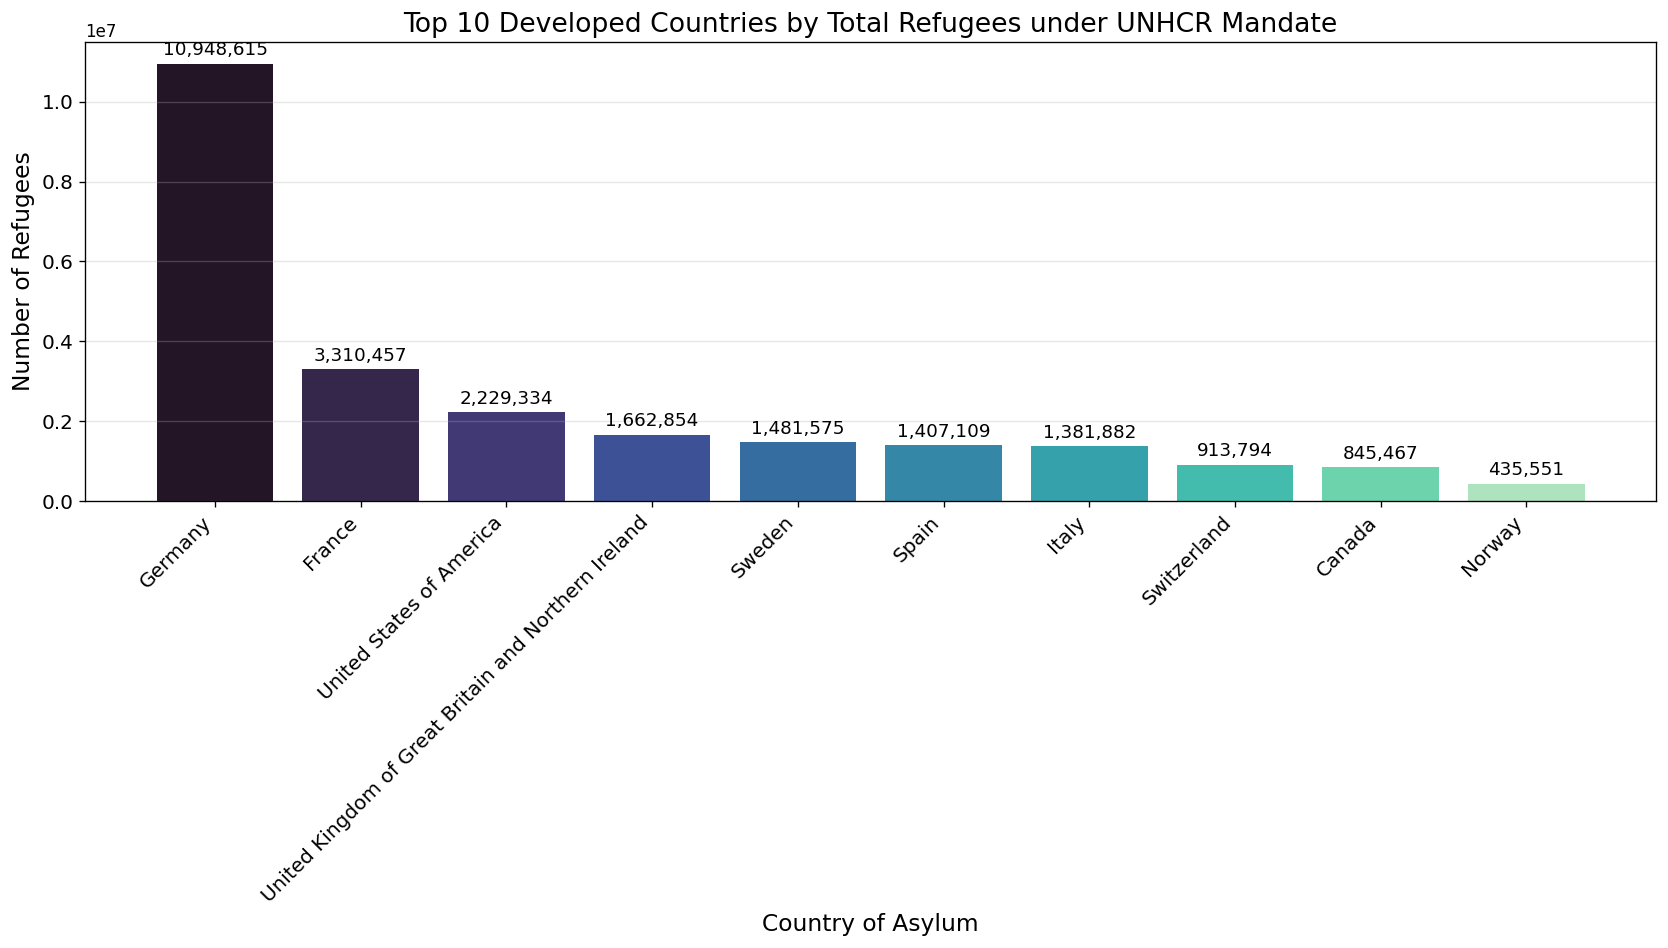

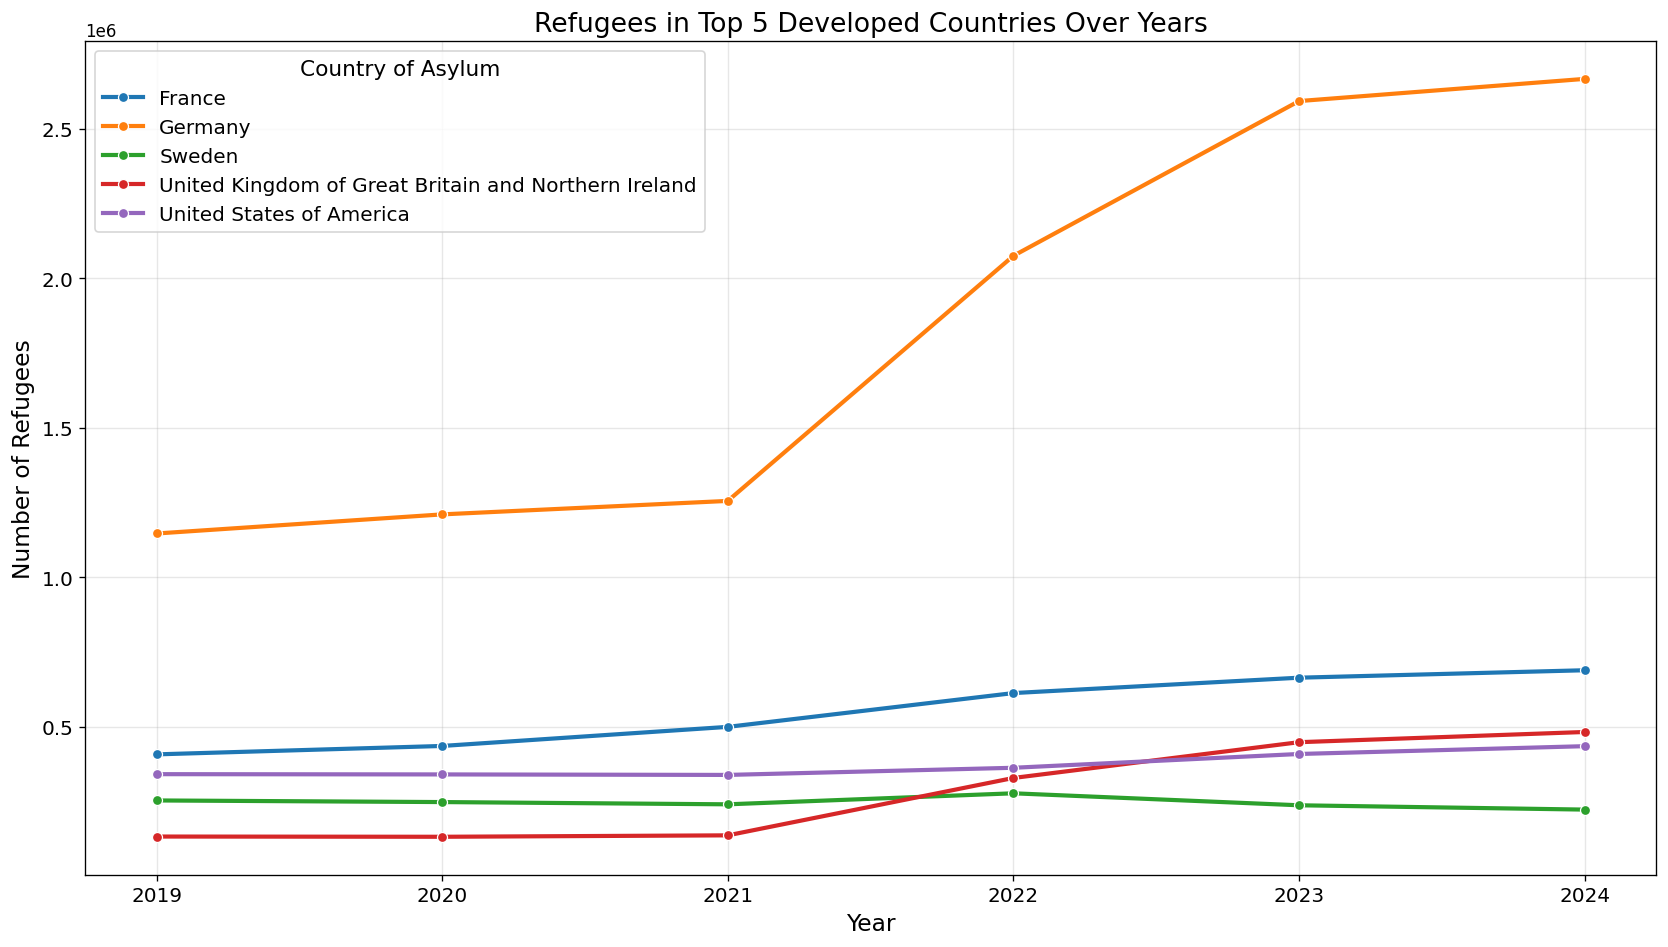

In [ ]:
# 9. Analysis 6: First World Countries Receiving Refugees

first_world = ['Australia', 'Canada', 'United Kingdom of Great Britain and Northern Ireland',
               'United States of America', 'Germany', 'France', 'Japan', 'Italy', 'Spain',
               'Sweden', 'Netherlands', 'Switzerland', 'Norway', 'Denmark', 'Finland']

first_world_refugees = ra_all[ra_all['Country of asylum'].isin(first_world)]
first_world_total = first_world_refugees.groupby('Country of asylum')[["Refugees under UNHCR's mandate"]].sum().reset_index()
first_world_total = first_world_total.sort_values(by="Refugees under UNHCR's mandate", ascending=False).head(10)

plt.figure(figsize=(14, 8))
bars = plt.bar(first_world_total['Country of asylum'],
               first_world_total["Refugees under UNHCR's mandate"],
               color=sns.color_palette("mako", 10))
plt.title('Top 10 Developed Countries by Total Refugees under UNHCR Mandate', fontsize=16)
plt.xlabel('Country of Asylum', fontsize=14)
plt.ylabel('Number of Refugees', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * first_world_total["Refugees under UNHCR's mandate"].max(),
             '{:,.0f}'.format(height), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

first_world_by_year = first_world_refugees.groupby(['Year', 'Country of asylum'])[["Refugees under UNHCR's mandate"]].sum().reset_index()
top5_first_world = first_world_total.head(5)['Country of asylum'].tolist()
first_world_top5 = first_world_by_year[first_world_by_year['Country of asylum'].isin(top5_first_world)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=first_world_top5, x='Year', y="Refugees under UNHCR's mandate",
             hue='Country of asylum', marker='o', linewidth=2.5)
plt.title('Refugees in Top 5 Developed Countries Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Refugees', fontsize=14)
plt.xticks(first_world_top5['Year'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Country of Asylum', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

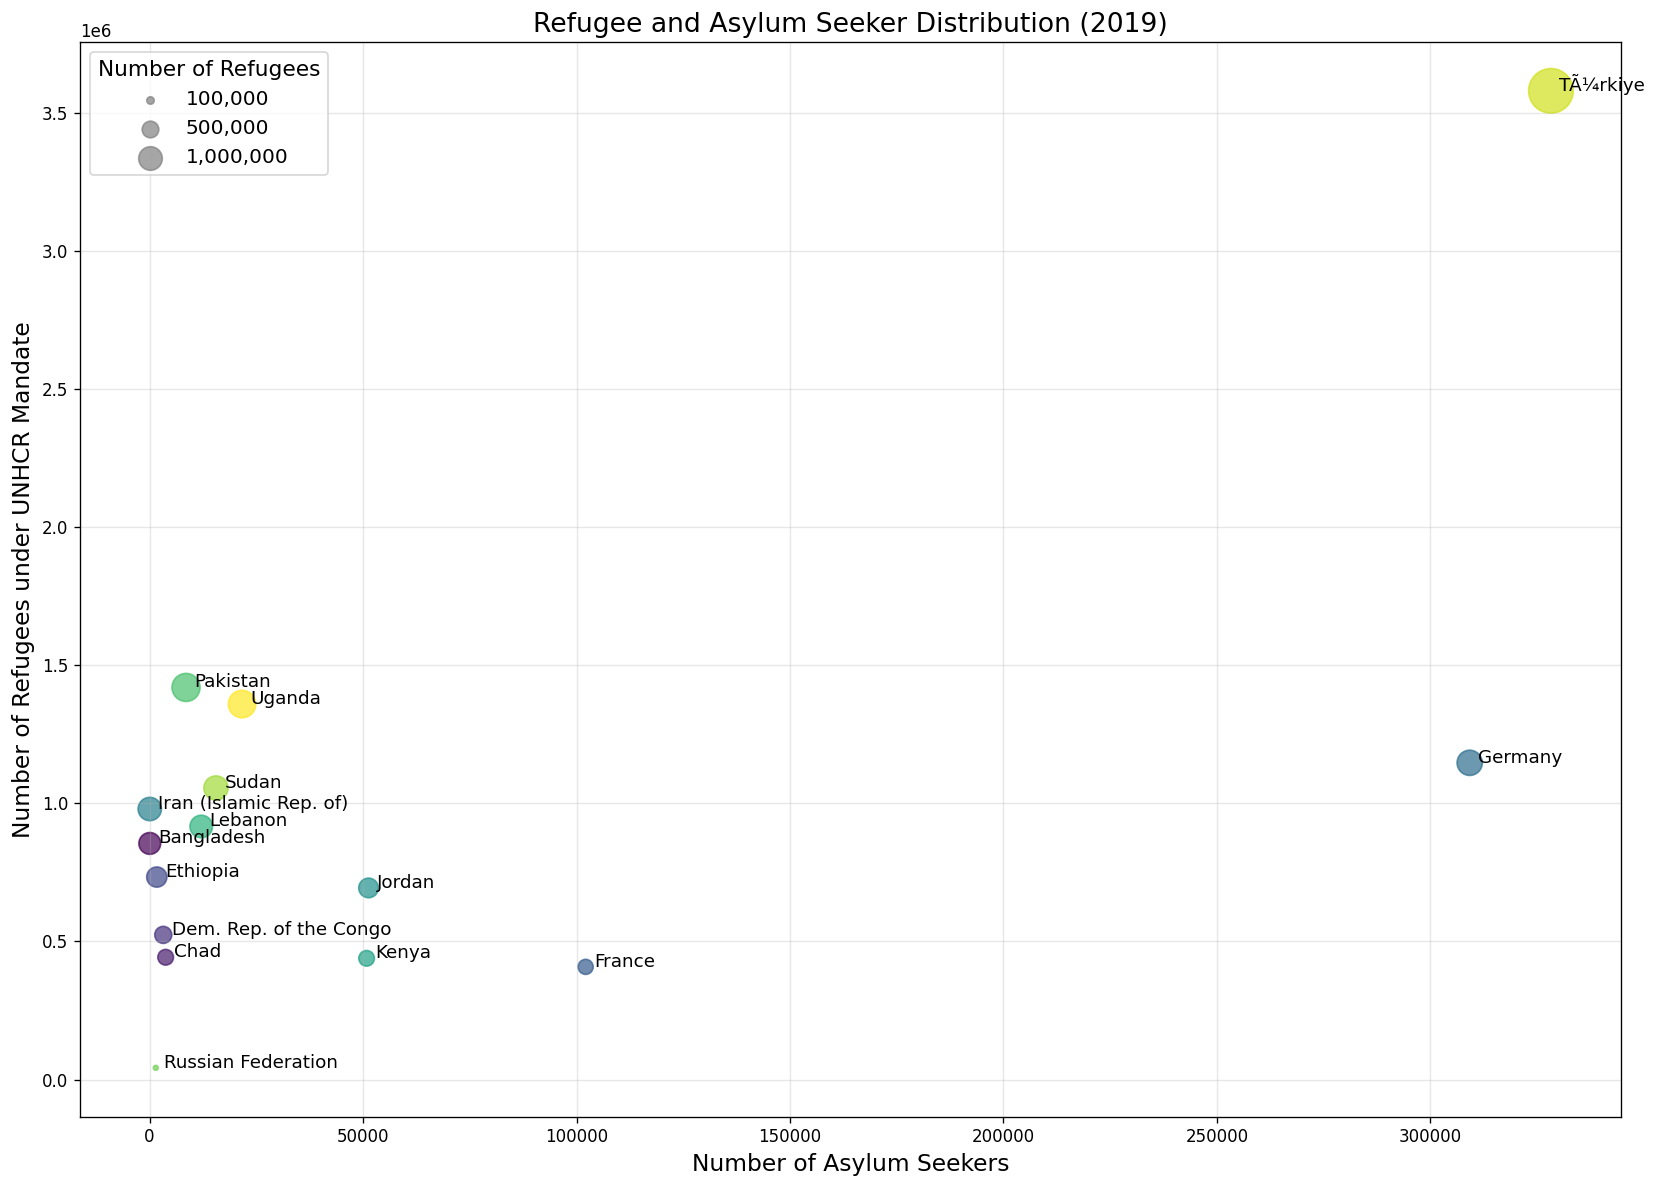

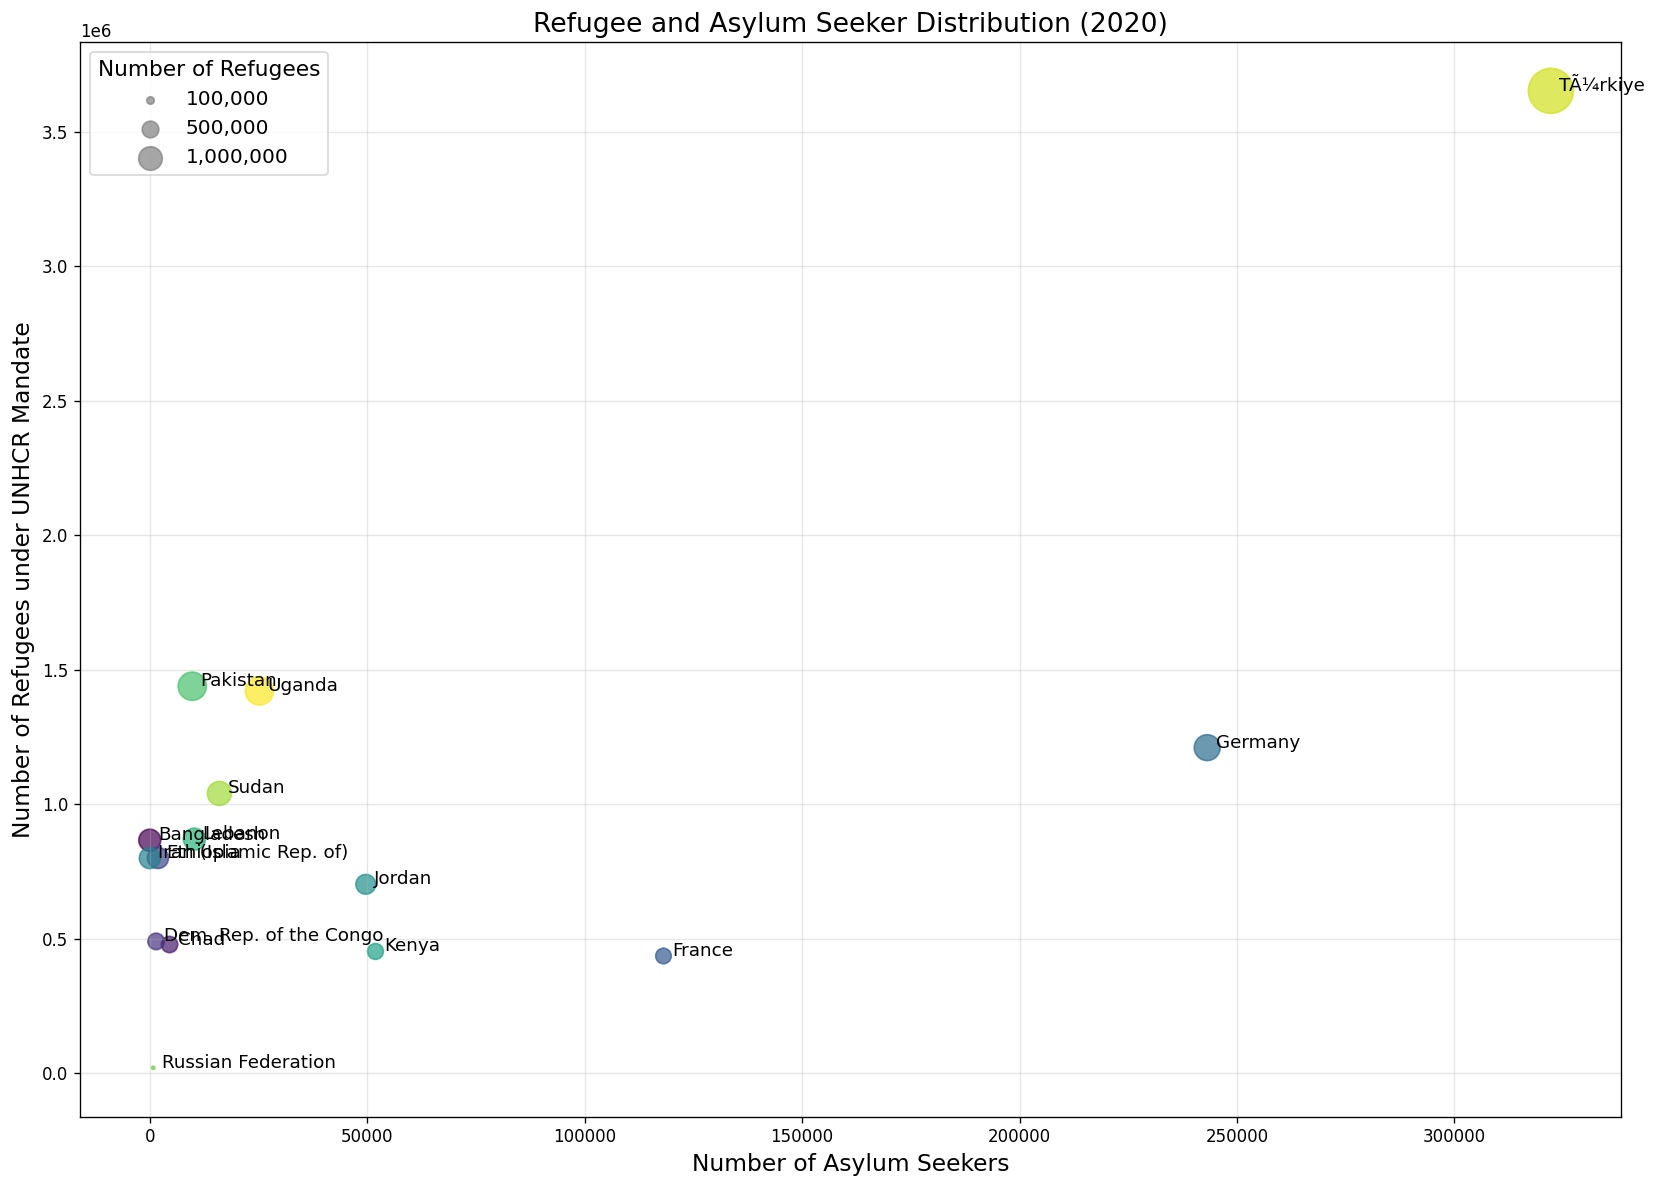

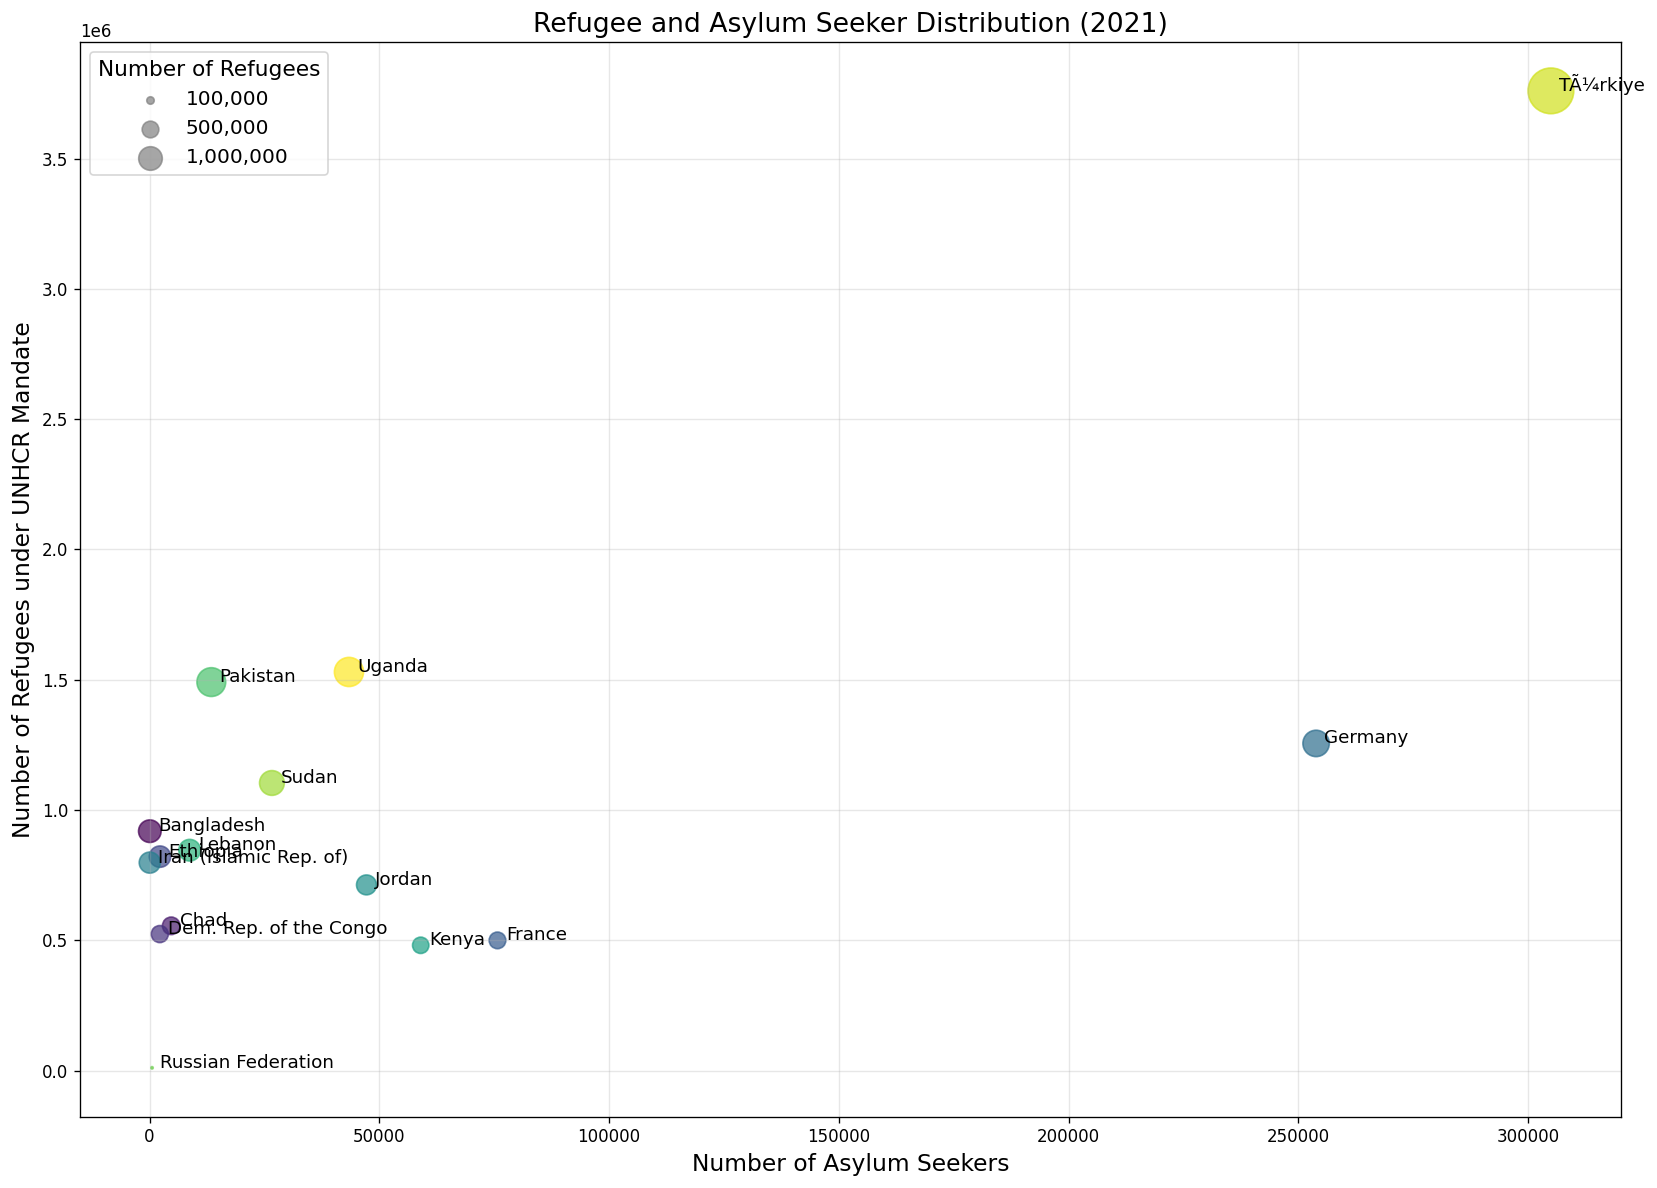

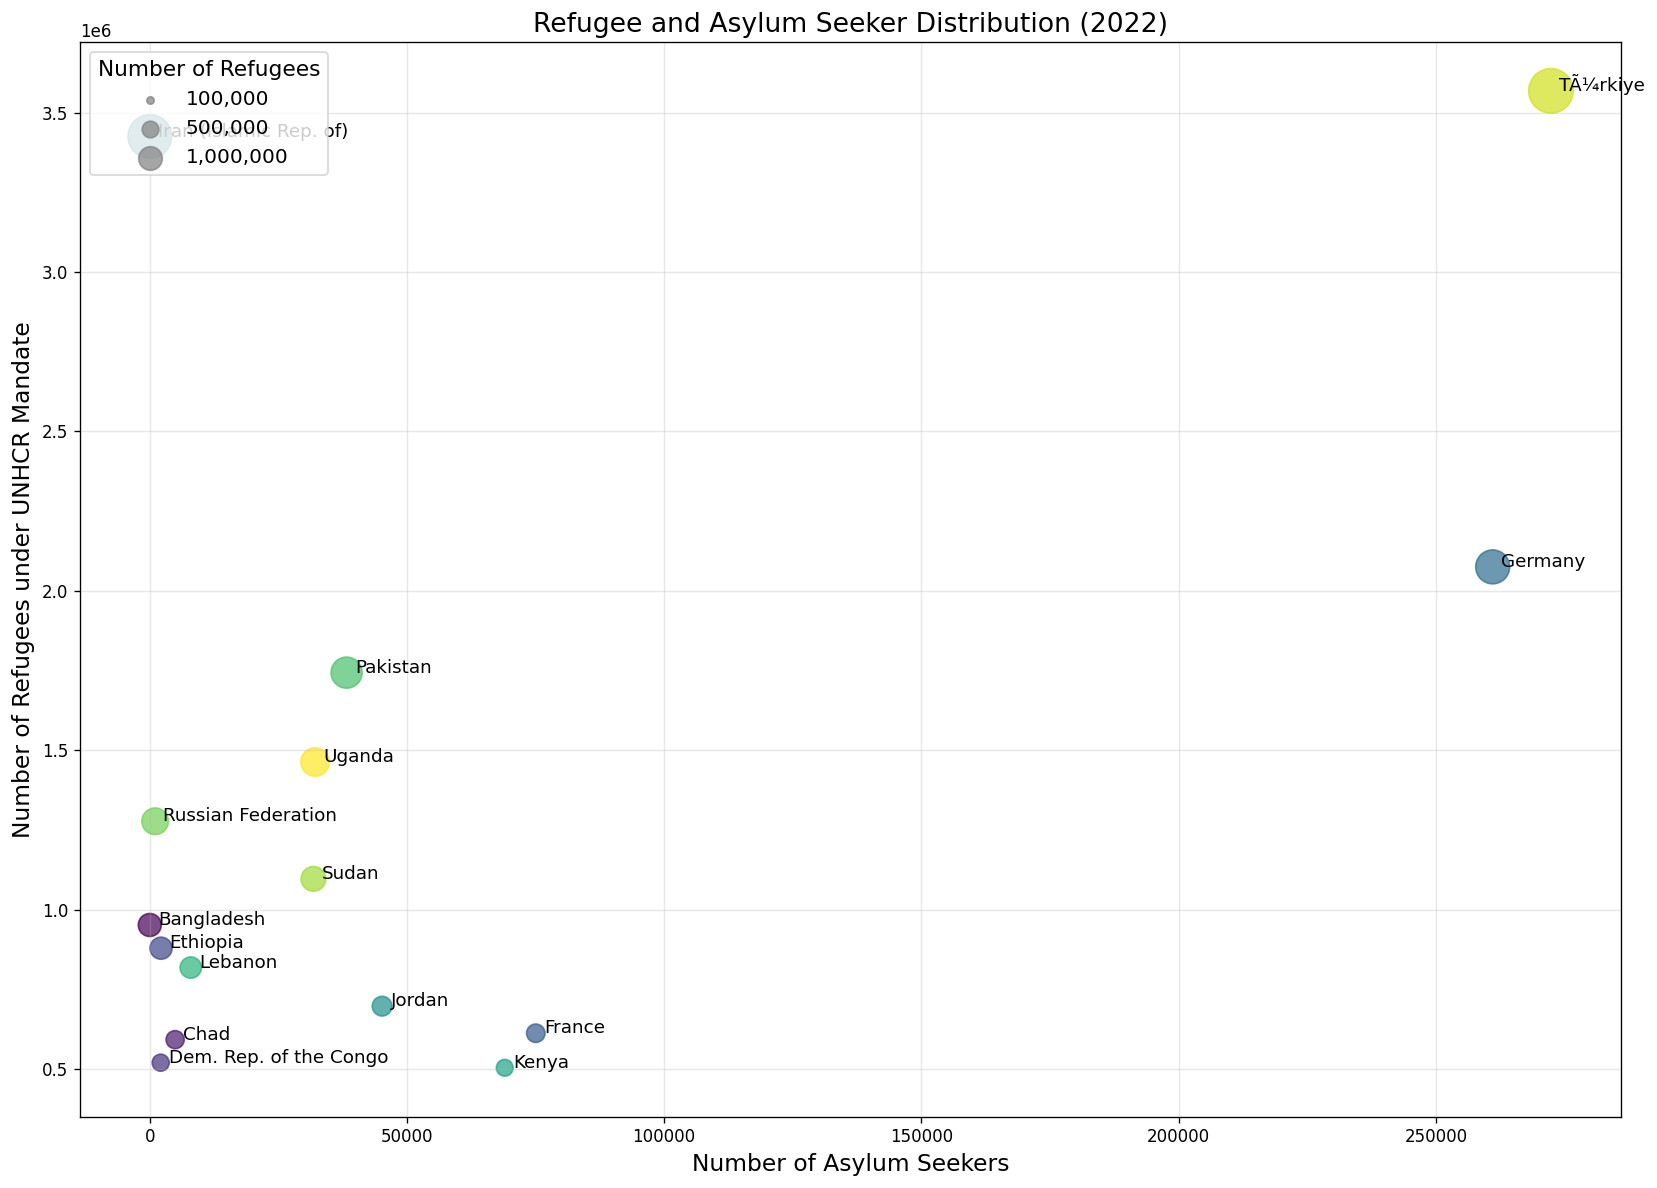

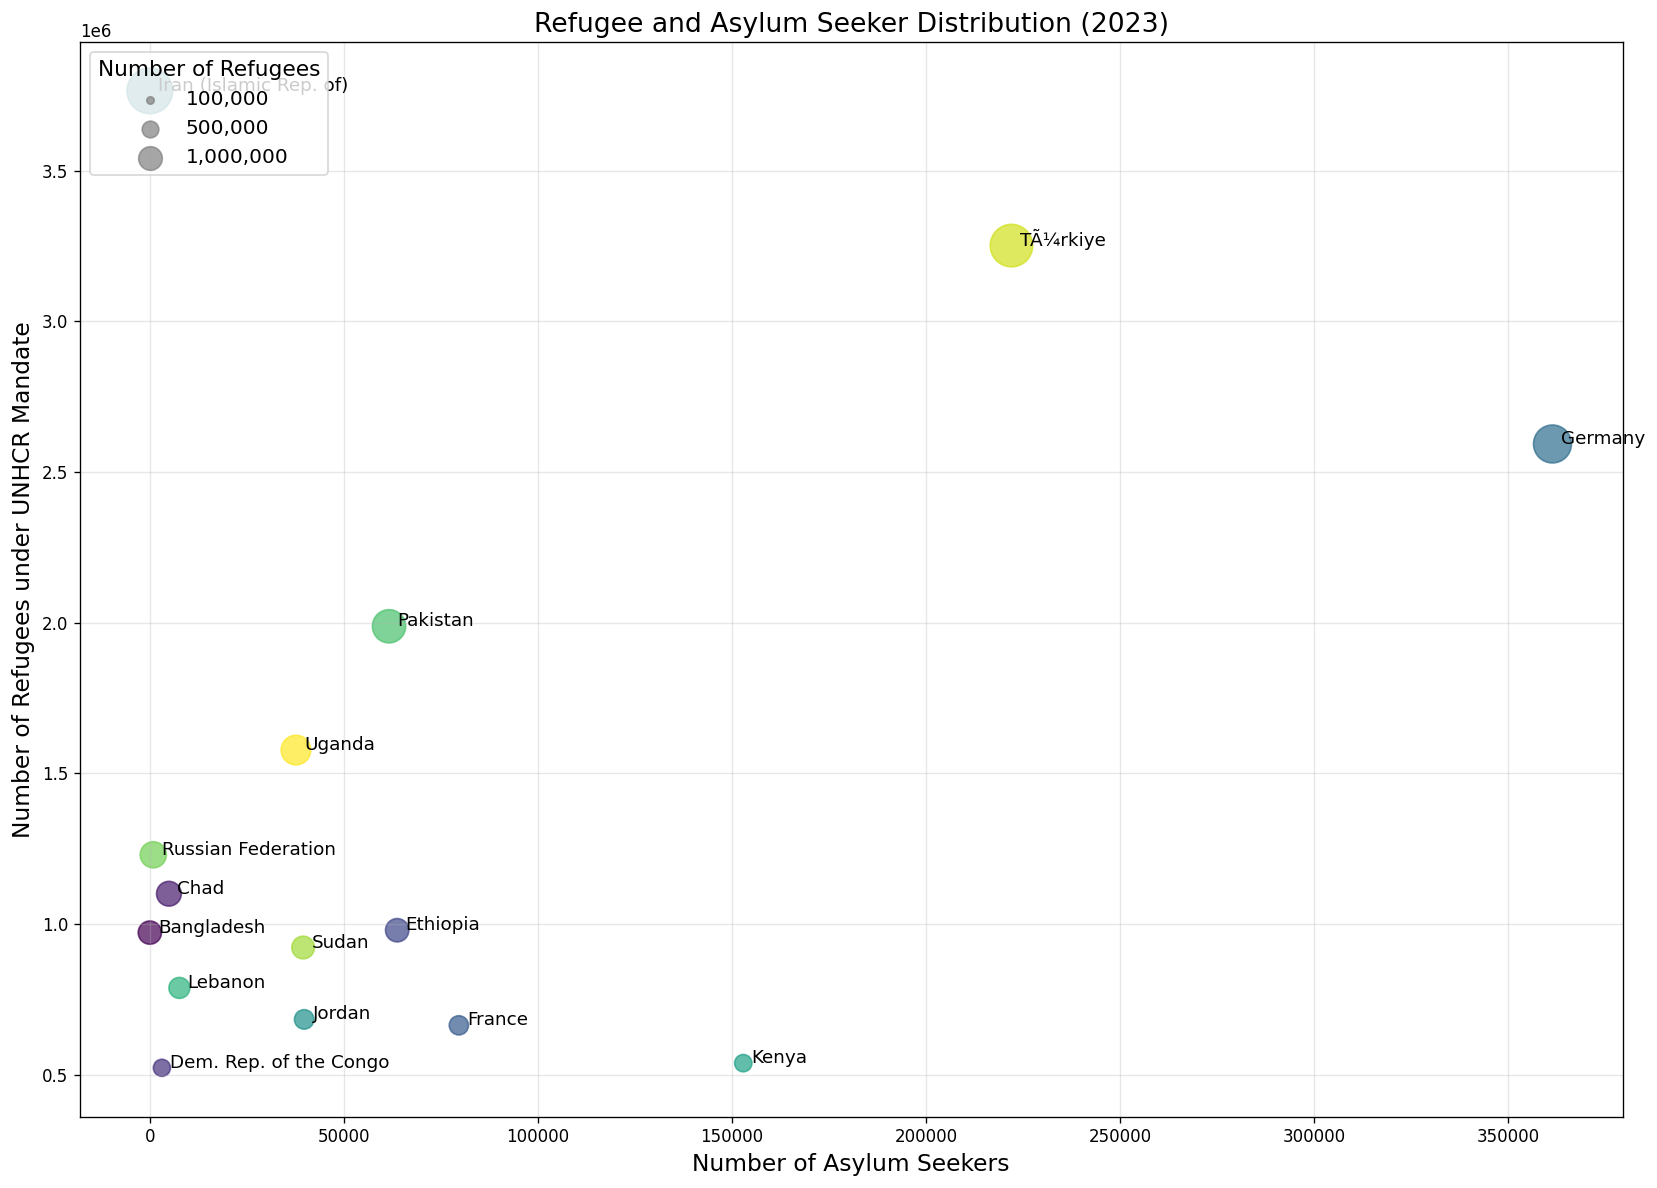

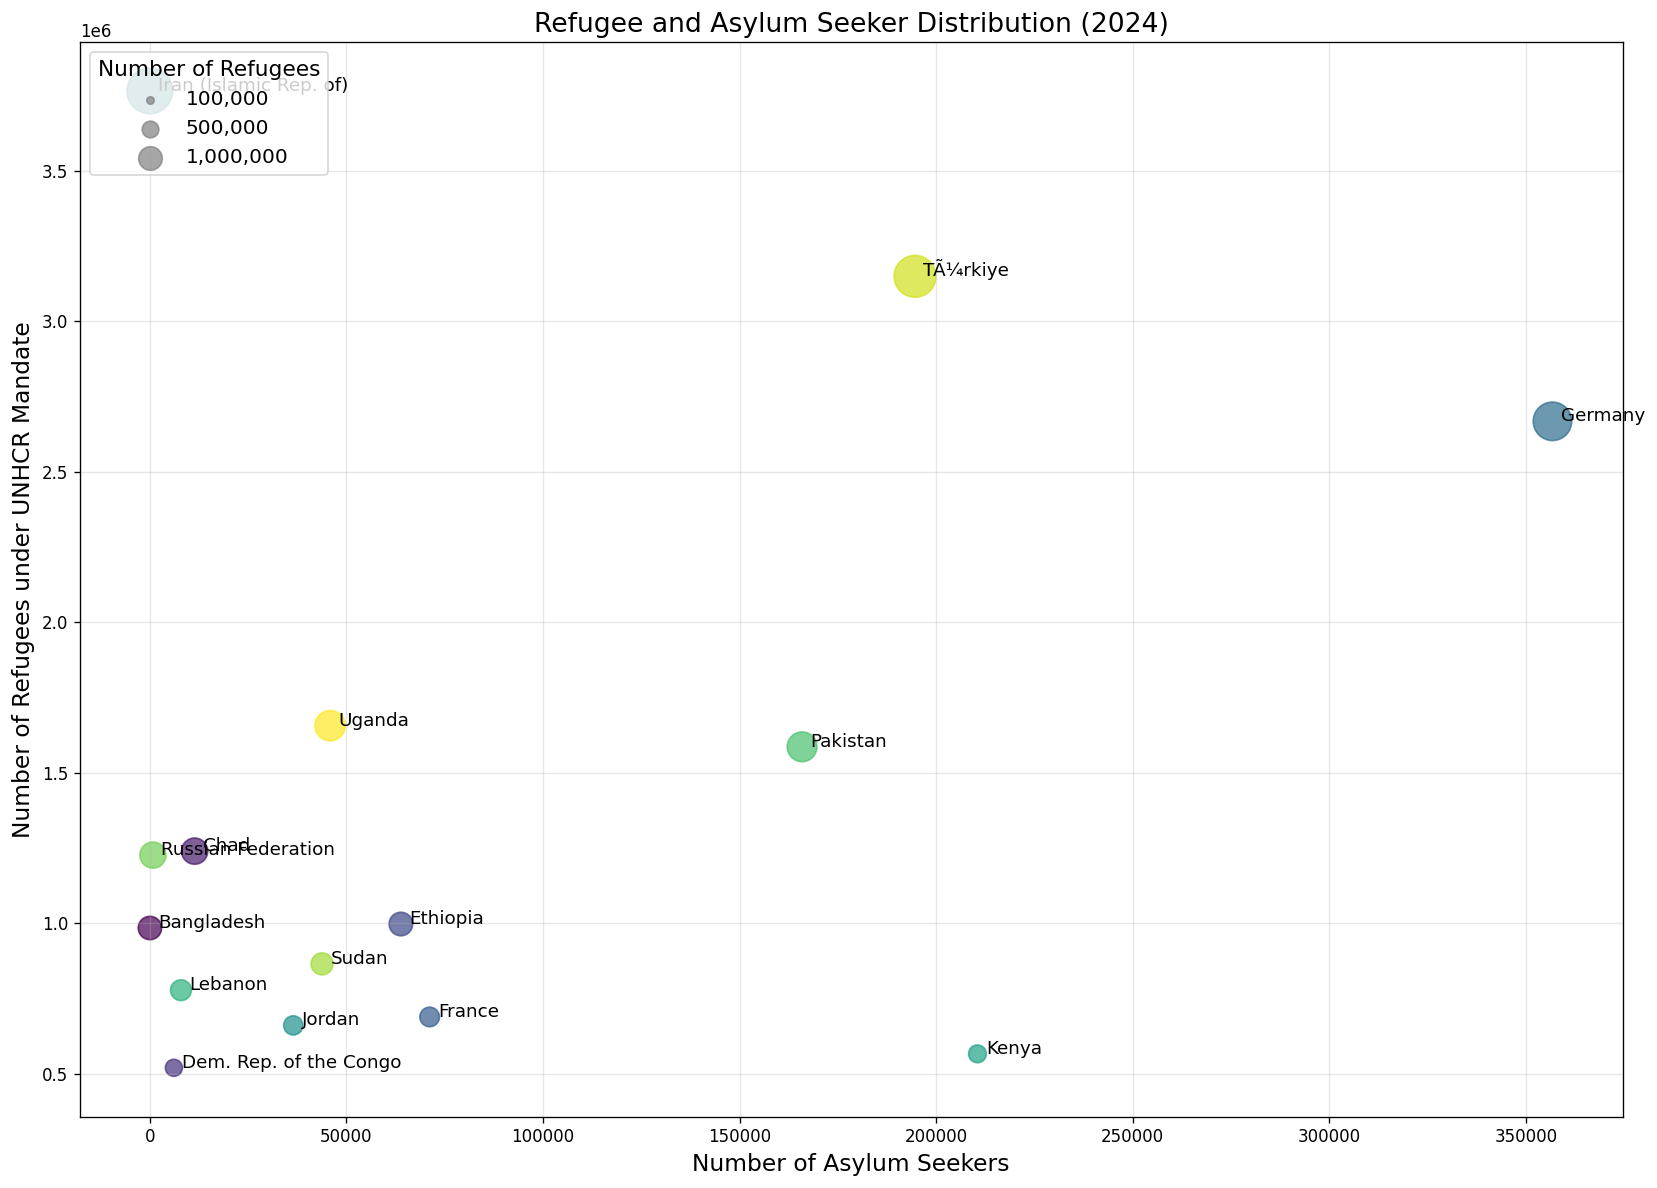

In [ ]:
# 10. Analysis 7: Gapminder-style Bubble Chart
bubble_data = ra_all.groupby(['Year', 'Country of asylum'])[
    ["Refugees under UNHCR's mandate", 'Asylum-seekers']].sum().reset_index()
bubble_data = bubble_data[bubble_data["Refugees under UNHCR's mandate"] > 0]

top15_asylum = bubble_data.groupby('Country of asylum')[
    ["Refugees under UNHCR's mandate"]].sum().nlargest(15, "Refugees under UNHCR's mandate").index
bubble_data_filtered = bubble_data[bubble_data['Country of asylum'].isin(top15_asylum)]

def plot_bubble_for_year(year_data, year):
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(
        x=year_data['Asylum-seekers'],
        y=year_data["Refugees under UNHCR's mandate"],
        s=year_data["Refugees under UNHCR's mandate"] / 5000,
        alpha=0.7,
        c=np.arange(len(year_data)),
        cmap='viridis'
    )
    for i, row in year_data.iterrows():
        plt.annotate(row['Country of asylum'],
                     xy=(row['Asylum-seekers'], row["Refugees under UNHCR's mandate"]),
                     xytext=(5, 0),
                     textcoords='offset points',
                     fontsize=11)
    plt.title(f'Refugee and Asylum Seeker Distribution ({year})', fontsize=16)
    plt.xlabel('Number of Asylum Seekers', fontsize=14)
    plt.ylabel('Number of Refugees under UNHCR Mandate', fontsize=14)
    plt.grid(True, alpha=0.3)
    sizes = [100000, 500000, 1000000]
    labels = ['100,000', '500,000', '1,000,000']
    handles = [plt.scatter([], [], s=size/5000, color='gray', alpha=0.7) for size in sizes]
    plt.legend(handles, labels, scatterpoints=1, title='Number of Refugees',
               loc='upper left', fontsize=12, title_fontsize=13)
    plt.tight_layout()
    plt.show()

for year in sorted(bubble_data_filtered['Year'].unique()):
    year_data = bubble_data_filtered[bubble_data_filtered['Year'] == year]
    plot_bubble_for_year(year_data, year)

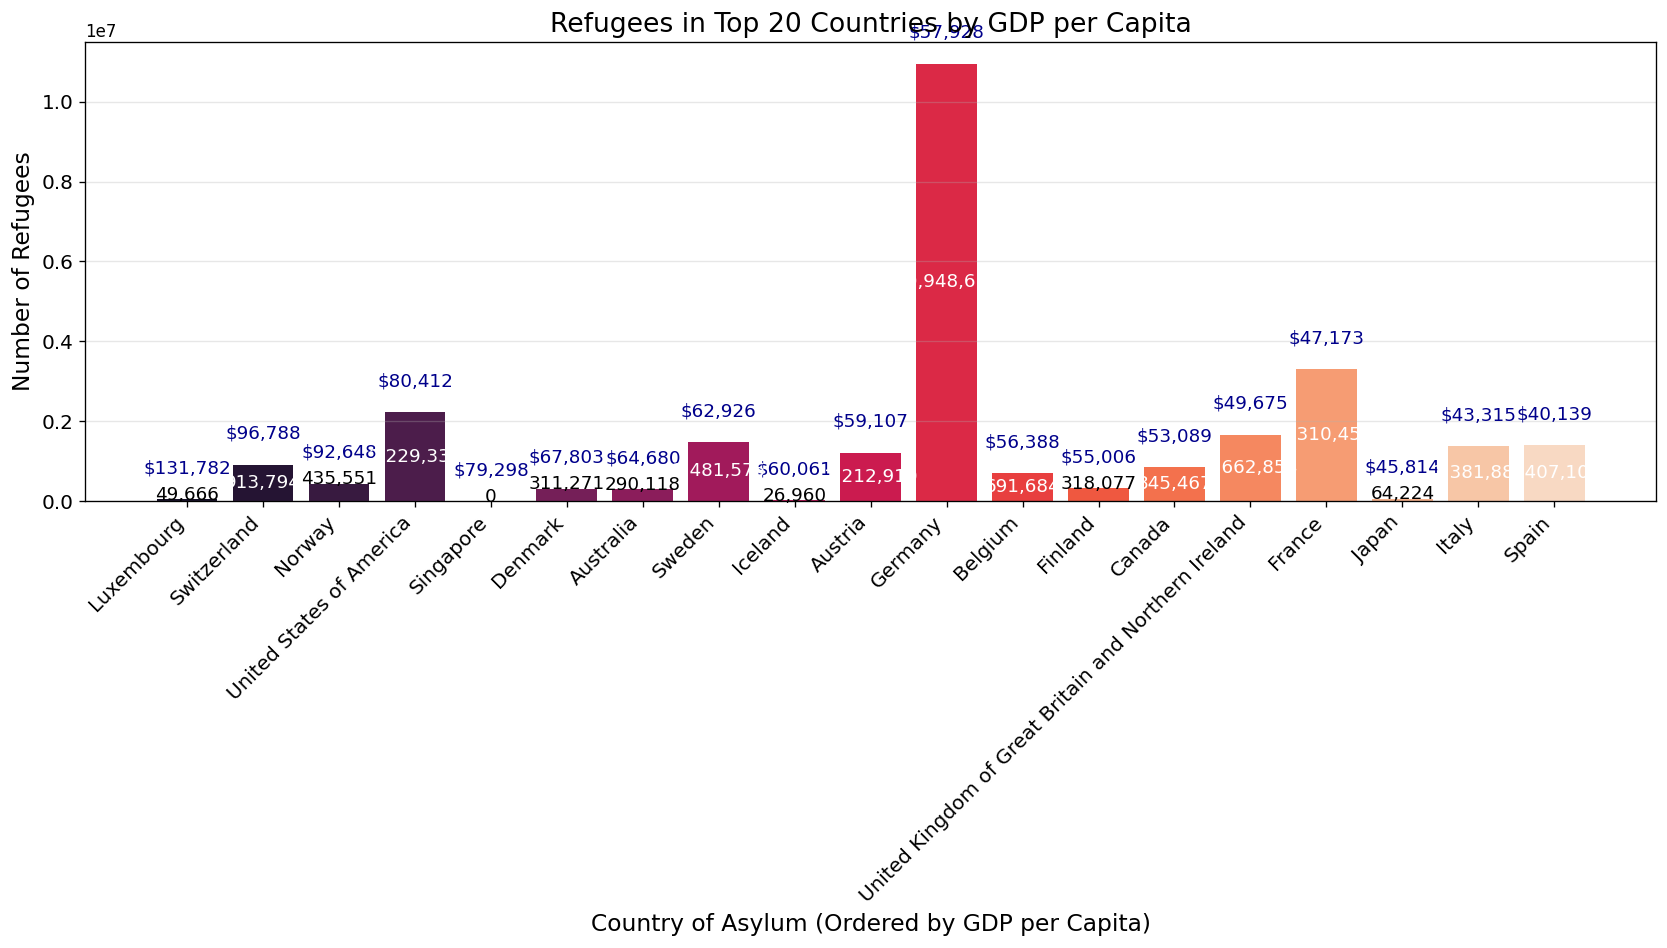

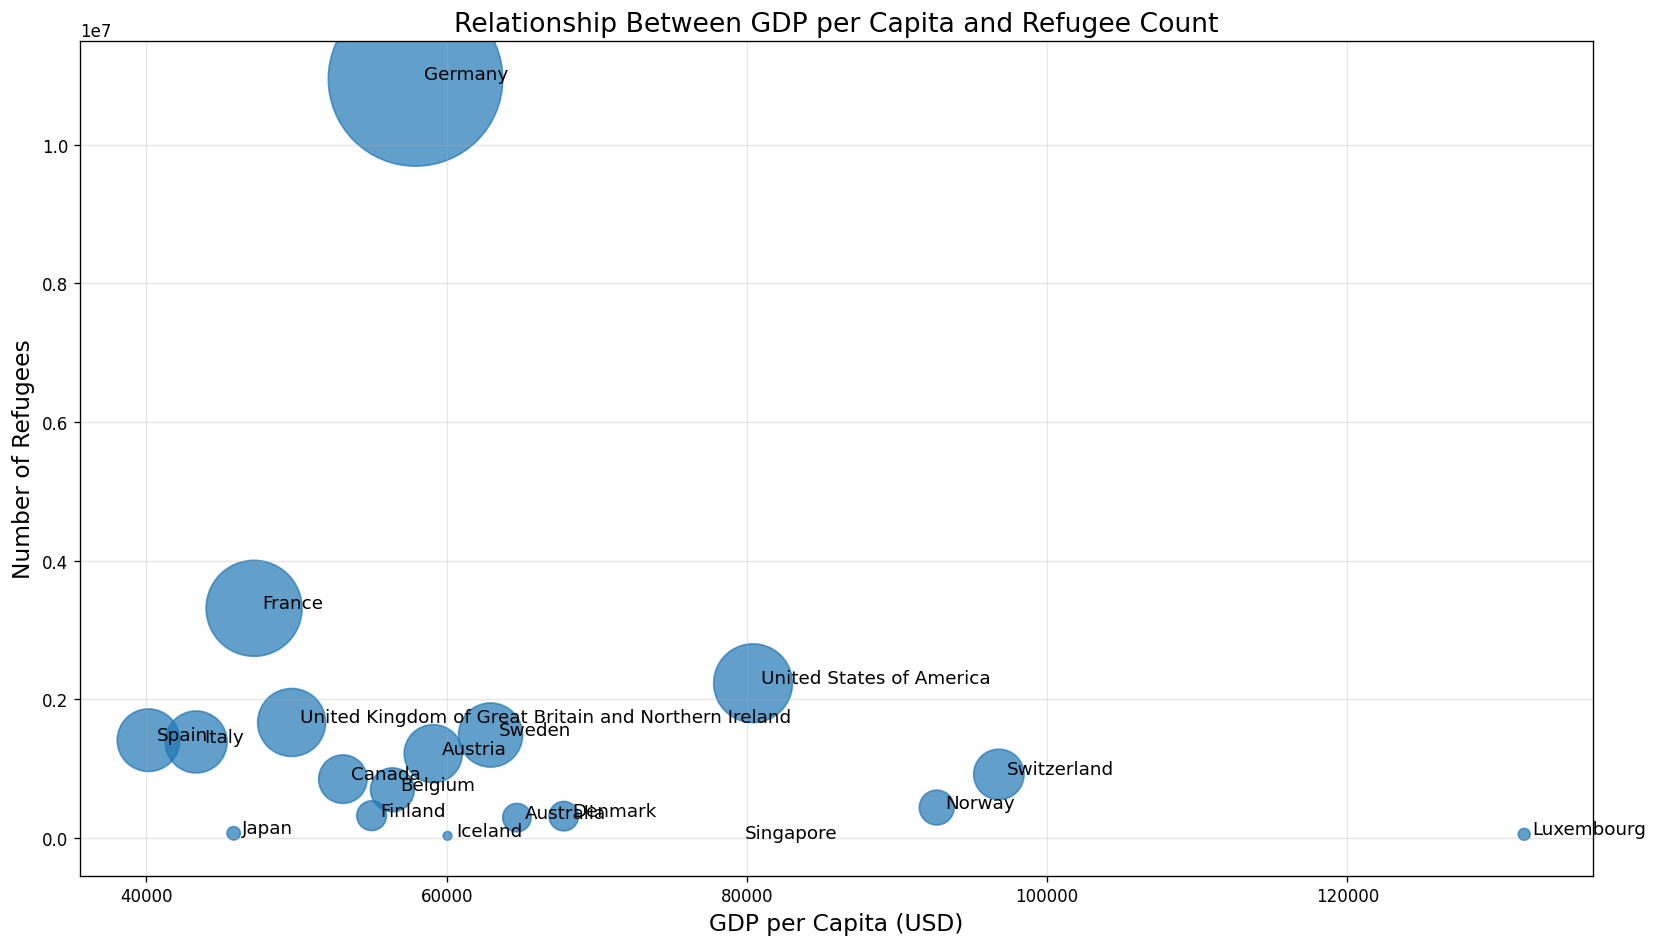

In [ ]:
# 11. Analysis 8: Refugees vs. GDP per Capita

gdp_per_capita = {
    'Luxembourg': 131782,
    'Switzerland': 96788,
    'Norway': 92648,
    'United States of America': 80412,
    'Singapore': 79298,
    'Denmark': 67803,
    'Australia': 64680,
    'Sweden': 62926,
    'Netherlands': 61285,
    'Iceland': 60061,
    'Austria': 59107,
    'Germany': 57928,
    'Belgium': 56388,
    'Finland': 55006,
    'Canada': 53089,
    'United Kingdom of Great Britain and Northern Ireland': 49675,
    'France': 47173,
    'Japan': 45814,
    'Italy': 43315,
    'Spain': 40139
}
gdp_df = pd.DataFrame(list(gdp_per_capita.items()), columns=['Country', 'GDP_per_capita'])

top20_richest = gdp_df.sort_values(by='GDP_per_capita', ascending=False).head(20)['Country'].tolist()
richest_refugees = ra_all[ra_all['Country of asylum'].isin(top20_richest)]
richest_total = richest_refugees.groupby('Country of asylum')[["Refugees under UNHCR's mandate"]].sum().reset_index()
richest_total = richest_total.merge(gdp_df, left_on='Country of asylum', right_on='Country')
richest_total = richest_total.sort_values(by='GDP_per_capita', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(richest_total['Country of asylum'],
               richest_total["Refugees under UNHCR's mandate"],
               color=sns.color_palette("rocket", len(richest_total)))
plt.title('Refugees in Top 20 Countries by GDP per Capita', fontsize=16)
plt.xlabel('Country of Asylum (Ordered by GDP per Capita)', fontsize=14)
plt.ylabel('Number of Refugees', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for i, (bar, gdp) in enumerate(zip(bars, richest_total['GDP_per_capita'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05 * richest_total["Refugees under UNHCR's mandate"].max(),
             '${:,.0f}'.format(gdp), ha='center', va='bottom', fontsize=11, color='darkblue')
for bar in bars:
    height = bar.get_height()
    y_pos = height / 2 if height > richest_total["Refugees under UNHCR's mandate"].max() * 0.05 else height + 0.01 * richest_total["Refugees under UNHCR's mandate"].max()
    color = 'white' if height > richest_total["Refugees under UNHCR's mandate"].max() * 0.05 else 'black'
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             '{:,.0f}'.format(height), ha='center', va='center', fontsize=11, color=color)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.scatter(richest_total['GDP_per_capita'], richest_total["Refugees under UNHCR's mandate"],
            s=richest_total["Refugees under UNHCR's mandate"]/1000, alpha=0.7)
for i, row in richest_total.iterrows():
    plt.annotate(row['Country of asylum'], xy=(row['GDP_per_capita'], row["Refugees under UNHCR's mandate"]),
                 xytext=(5, 0), textcoords='offset points', fontsize=11)
plt.title('Relationship Between GDP per Capita and Refugee Count', fontsize=16)
plt.xlabel('GDP per Capita (USD)', fontsize=14)
plt.ylabel('Number of Refugees', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Comprehensive Dashboard for Year 2024
Total Refugees: 31,956,584
Total Asylum Seekers: 7,996,077
Total Returned Refugees: 433,527
Total IDPs: 67,053,895
Total Stateless Persons: 4,368,258


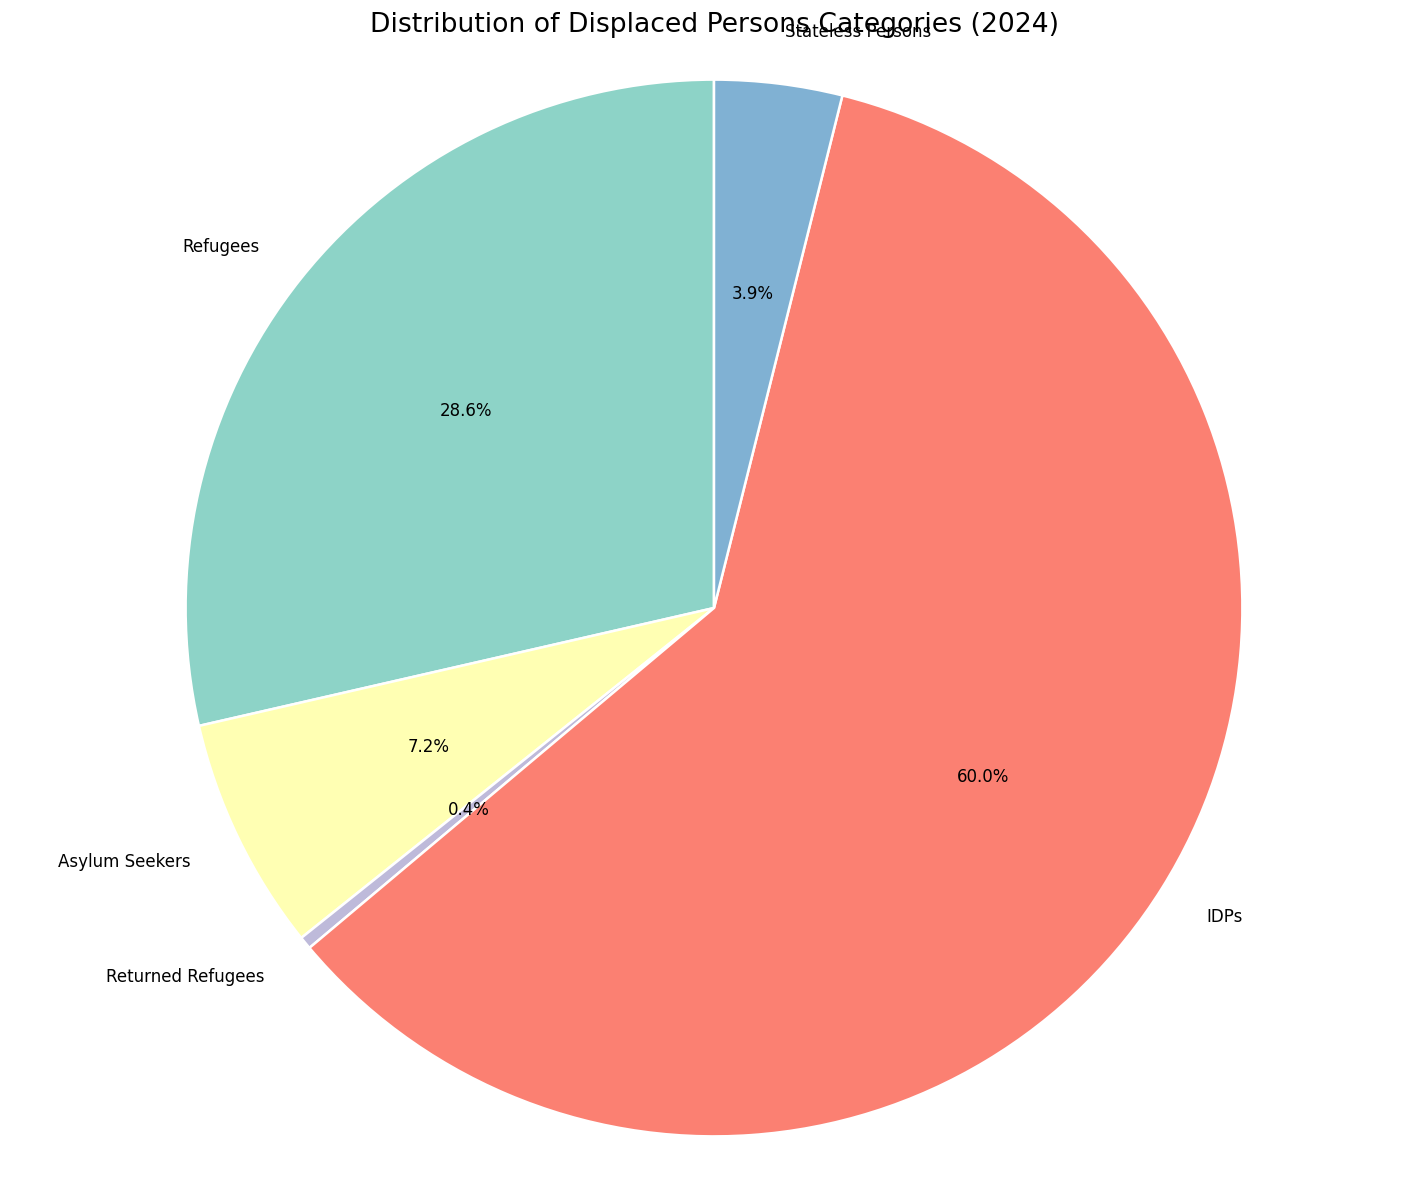

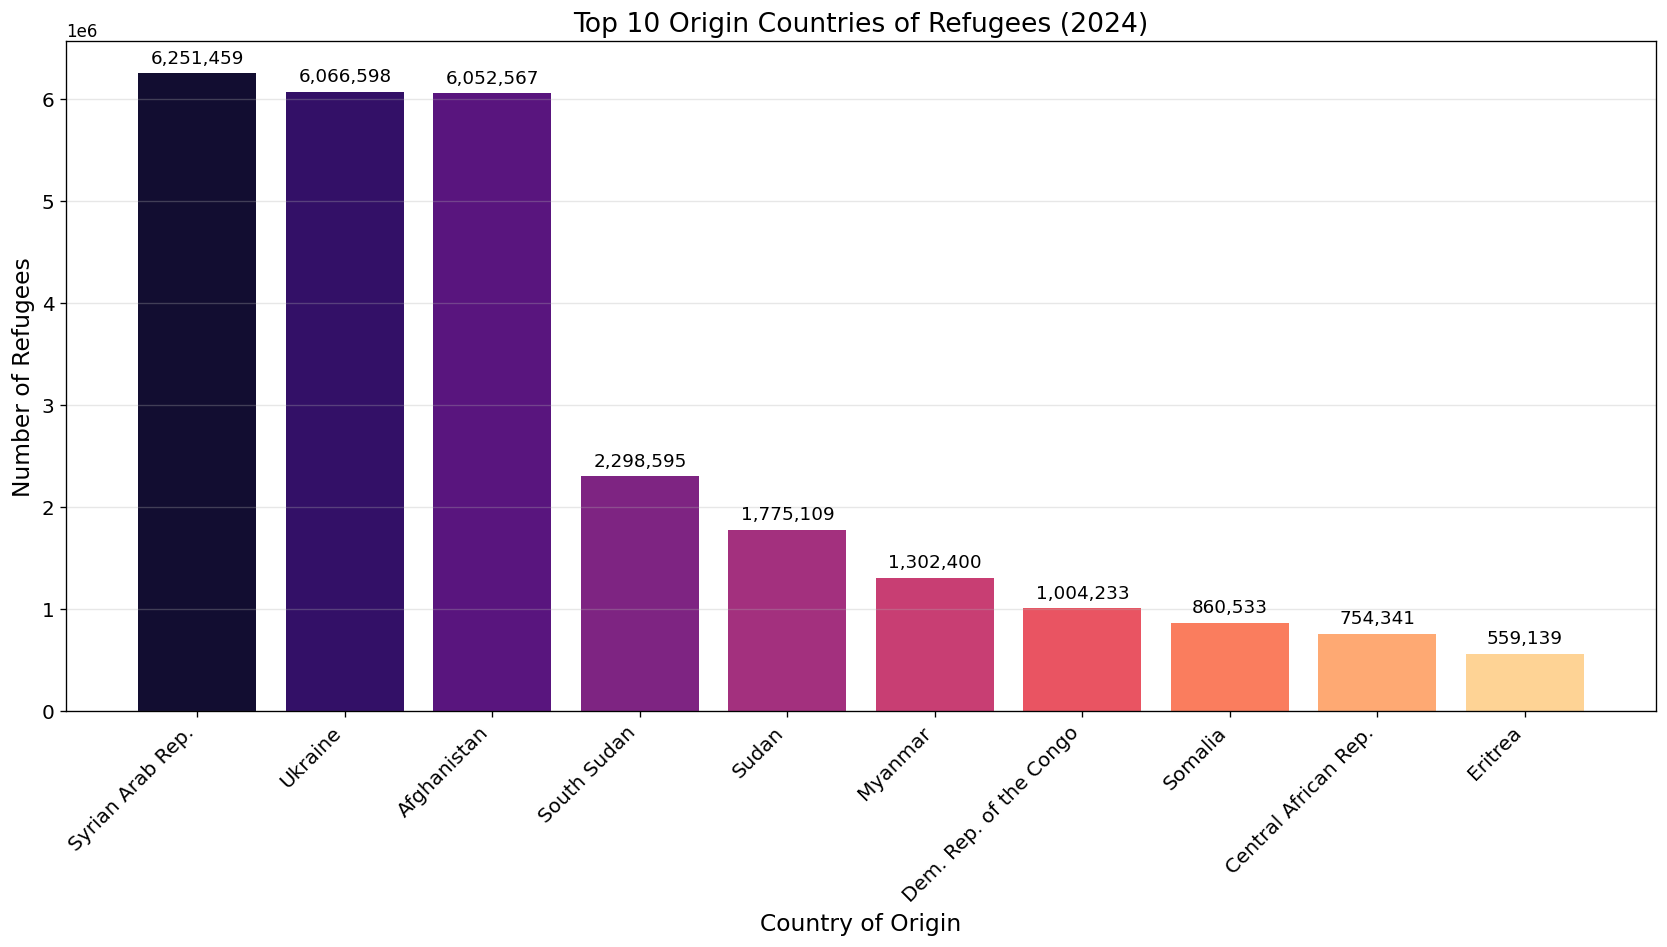


Analysis Complete!


In [ ]:
# 12. Analysis 9: Comprehensive Dashboard for Latest Year
latest_year = ra_all['Year'].max()
latest_data = ra_all[ra_all['Year'] == latest_year]

print(f"\nComprehensive Dashboard for Year {latest_year}")
total_refugees = latest_data["Refugees under UNHCR's mandate"].sum()
total_asylum = latest_data['Asylum-seekers'].sum()
total_returned = latest_data['Returned refugees'].sum()
total_idps = latest_data['IDPs of concern to UNHCR'].sum()
total_stateless = latest_data['Stateless persons'].sum()

print(f"Total Refugees: {total_refugees:,.0f}")
print(f"Total Asylum Seekers: {total_asylum:,.0f}")
print(f"Total Returned Refugees: {total_returned:,.0f}")
print(f"Total IDPs: {total_idps:,.0f}")
print(f"Total Stateless Persons: {total_stateless:,.0f}")

categories = ['Refugees', 'Asylum Seekers', 'Returned Refugees', 'IDPs', 'Stateless Persons']
values = [total_refugees, total_asylum, total_returned, total_idps, total_stateless]

plt.figure(figsize=(12, 10))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90,
        colors=sns.color_palette('Set3', len(categories)),
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
plt.title(f'Distribution of Displaced Persons Categories ({latest_year})', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

top_origins_latest = latest_data.groupby('Country of origin')[["Refugees under UNHCR's mandate"]].sum().reset_index()
top_origins_latest = top_origins_latest.sort_values(by="Refugees under UNHCR's mandate", ascending=False).head(10)

plt.figure(figsize=(14, 8))
bars = plt.bar(top_origins_latest['Country of origin'],
               top_origins_latest["Refugees under UNHCR's mandate"],
               color=sns.color_palette("magma", 10))
plt.title(f'Top 10 Origin Countries of Refugees ({latest_year})', fontsize=16)
plt.xlabel('Country of Origin', fontsize=14)
plt.ylabel('Number of Refugees', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * top_origins_latest["Refugees under UNHCR's mandate"].max(),
             '{:,.0f}'.format(height), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")
